In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:47529")
client

<Client: 'tcp://127.0.0.1:47529' processes=10 threads=50, memory=211.66 GB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
import os.path as op
import os
import xrft
import gsw
import time
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
from xlayers import finegrid, layers
from xlayers.core import layers_numpy, layers_apply

In [4]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'

In [5]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ystart = -10
yNstart = 15
yend = 50

xchunk = 250
membchunk = 1
nremap = 60

# Try out Dec. 27-31, 1963

In [6]:
for nmemb in range(24,36):
    if nmemb == 24:
        dsnap = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' % nmemb), 
                                grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                prefix=['diag_ocnSnap',
                                        'diag_Tbgt2D','diag_Tbgt3D',
                                        'diag_Sbgt2D','diag_Sbgt3D'], delta_t=2e2,
#                                 iters=range(943920-2160,943920+2160,2160),
                                iters=943920, 
                                chunks={'XC':xchunk,'XG':xchunk}
                               ).isel(time=-1)
#         dsave = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' % nmemb), 
#                                 grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
#                                 prefix=['diag_ocnTave','diag_ocnSurf'], delta_t=2e2,
#         #                              iters=range(788400+2160,943920+2160,2160)
#                                 iters=943920, chunks={'XC':xchunk,'XG':xchunk}
#                                 ).isel(time=-1)
    else:
        dsnap = xr.concat([dsnap, open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' 
                                                          % nmemb), 
                                                  grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                  prefix=['diag_ocnSnap',
                                                          'diag_Tbgt2D','diag_Tbgt3D',
                                                          'diag_Sbgt2D','diag_Sbgt3D'], delta_t=2e2,
#                                                   iters=range(943920-2160,943920+2160,2160),
                                                  iters=943920, 
                                                  chunks={'XC':xchunk,'XG':xchunk}
                                                 ).isel(time=-1)],
                          dim='nmemb')
#         dsave = xr.concat([dsave, open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' 
#                                                           % nmemb), 
#                                                   grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
#                                                   prefix=['diag_ocnTave','diag_ocnSurf'], delta_t=2e2,
#         #                                             iters=range(788400+2160,943920+2160,2160)
#                                                   iters=943920, chunks={'XC':xchunk,'XG':xchunk}
#                                                  ).isel(time=-1)],
#                           dim='nmemb')
dsnap.coords['nmemb'] = ('nmemb', range(12))
dsnap

<xarray.Dataset>
Dimensions:   (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, nmemb: 12)
Coordinates:
    maskW     (Z, YC, XG) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    hFacC     (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    maskInW   (YC, XG) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    hFacW     (Z, YC, XG) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    time      float64 1.888e+08
    drC       (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    maskInC   (YC, XC) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    rAz       (YG, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    PHrefC    (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    dyG       (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    rAw       (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    rAs       (YG, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    hFacS     (Z, YG, XC) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    drF       (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    dyC       (YG, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    Depth     (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    dxC       (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    iter      int64 dask.array<chunksize=(), meta=np.ndarray>
    PHrefF    (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    maskS     (Z, YG, XC) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    dxG       (YG, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    maskC     (Z, YC, XC) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    rA        (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    maskInS   (YG, XC) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
  * YC        (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * YG        (YG) >f4 -19.9583 -19.874968 -19.791634 ... 54.875034 54.95837
  * XC        (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * Zl        (Zl) >f4 0.0 -6.0935454 -12.814552 ... -5499.9937 -5749.9097
  * Zu        (Zu) >f4 -6.0935454 -12.814552 -19.91338 ... -5749.9097 -6000.3726
  * XG        (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * Zp1       (Zp1) >f4 0.0 -6.0935454 -12.814552 ... -5749.9097 -6000.3726
  * Z         (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * nmemb     (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    TOTTTEND  (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    ADVr_TH   (nmemb, Zl, YC, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    ADVx_TH   (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    ADVy_TH   (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    Diss_TH   (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    THETA     (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    SALT      (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    UVEL      (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    VVEL      (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    WVEL      (nmemb, Zl, YC, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    PHIHYD    (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    TFLUX     (nmemb, YC, XC) float32 dask.array<chunksize=(1, 900, 250), meta=np.ndarray>
    oceQsw    (nmemb, YC, XC) float32 dask.array<chunksize=(1, 900, 250), meta=np.ndarray>
    WTHMASS   (nmemb, YC, XC) float32 dask.array<chunksize=(1, 900, 250), meta=np.ndarray>
    SFLUX     (nmemb, YC, XC) float3

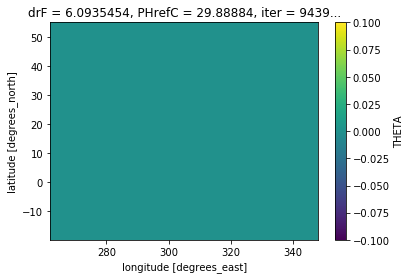

In [25]:
(dsnap.THETA[5,0]-dsnap.THETA.isel(nmemb=5)[0]).plot()

In [9]:
def sound_speed(s,th,p):
    th2 = th**2
    sqrts = np.sqrt(s)

    anum =     (       9.99843699e2 +
                 th *( 7.35212840 +
                 th *(-5.45928211e-2 +
                 th *  3.98476704e-4)) +
                  s *( 2.96938239 -
                 th *  7.23268813e-3 +
                  s *  2.12382341e-3))

    aden =     (       1. +
                 th *( 7.28606739e-3 +
                 th *(-4.60835542e-5 +
                 th *( 3.68390573e-7 +
                 th *  1.80809186e-10))) +
                  s *( 2.14691708e-3 -
                 th *( 9.27062484e-6 +
                th2 *  1.78343643e-10) +
              sqrts *( 4.76534122e-6 +
                th2 *  1.63410736e-9)))
    
    
    anum_th =   (      7.352128400 + 
                 th *(-1.091856422e-01 + 
                 th *  1.195430112e-03) -
                  s *  7.232688130e-03)

    aden_th =   (      7.286067390e-03 +
                 th *(-9.216710840e-05 + 
                 th *( 1.105171719e-06 + 
                 th *  7.232367440e-10)) +
                  s *(-9.270624840e-06 - 
                th2 *  5.350309290e-10 + 
          th *sqrts *  3.268214720e-09))

    anum_s =    (      2.96938239 -
                 th *  7.23268813e-03 +
                  s *  4.24764682e-03)

    aden_s =    (      2.14691708e-03 -
                 th *( 9.27062484e-06 +
                th2 *  1.78343643e-10) +
              sqrts *( 7.14801183e-06 + 
                th2 *  2.45116104e-09))


    anum_p =   (       1.04004591e-2 +
                th2 *  1.03970529e-7 +
                  s *  5.18761880e-6)

    aden_p =           5.30848875e-6*xr.ones_like(s)


    s = s.where(p!=0.)
    th = th.where(p!=0.) 
    th2 = th2.where(p!=0.) 
    p = p.where(p!=0.)
    anum = anum.where(p!=0.)
    aden = aden.where(p!=0.)
    anum_p = anum_p.where(p!=0.)
    aden_p = aden_p.where(p!=0.)

    pth = p * th

    anum = anum +                        p *( 1.04004591e-2 +
                                       th2 *  1.03970529e-7 +
                                         s *  5.18761880e-6 -
                                         p *( 3.24041825e-8 +
                                       th2 *  1.23869360e-11))

    aden = aden +                        p *( 5.30848875e-6 -
                                 pth *(th2 *  3.03175128e-16 +
                                         p *  1.27934137e-17))
  
#####################
    anum_s = anum_s +                    p *  5.1876188e-06

    anum_th = anum_th +                pth *( 2.07941058e-07 - 
                                         p *  2.47738720e-11)

    aden_th = aden_th -         p *p *(th2 *  9.09525384e-16 +
                                         p *  1.27934137e-17) 

#####################
    anum_p = anum_p -                    p *( 6.4808365e-8 +
                                       th2 *  2.4773872e-11)

    aden_p = aden_p -            pth *(th2 *  6.06350256e-16 +
                                         p *  3.83802411e-17)


    rec_aden = aden**-1


    rho = anum*rec_aden
    rho_s = (anum_s - aden_s*rho)*rec_aden
    rho_th = (anum_th - aden_th*rho)*rec_aden
    rho_p = (anum_p - aden_p*rho)*rec_aden
    
    return rho_s, rho_th, np.sqrt(rho_p*1e-4)**-1

In [10]:
rho_s,rho_th,cs = sound_speed(dsnap.SALT.where(dsnap.maskC!=0.), 
                              dsnap.THETA.where(dsnap.maskC!=0.), 
                              -grav*dsnap.Z*rhoConst*1e-4)
cs

<xarray.DataArray (nmemb: 12, Z: 46, YC: 900, XC: 1000)>
dask.array<pow, shape=(12, 46, 900, 1000), dtype=float32, chunksize=(1, 46, 900, 250), chunktype=numpy.ndarray>
Coordinates:
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    time     float64 1.888e+08
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    rA       (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11

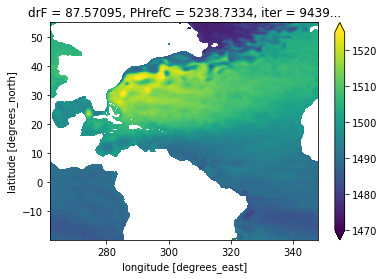

In [143]:
cs.isel(nmemb=0).sel(Z=-500, method='nearest').plot(vmin=1470, vmax=1525)

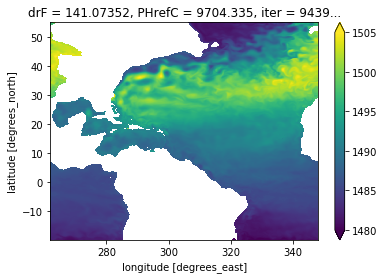

In [141]:
cs.isel(nmemb=0).sel(Z=-1000, method='nearest').plot(vmin=1480, vmax=1505)

In [7]:
dsnap = dsnap.chunk({'XC':xchunk,'XG':xchunk})
dsnap

<xarray.Dataset>
Dimensions:   (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, nmemb: 12, time: 2)
Coordinates:
    drC       (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    dyG       (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    PHrefF    (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    rAz       (YG, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    rA        (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    rAw       (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    rAs       (YG, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    maskC     (Z, YC, XC) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    dyC       (YG, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    maskS     (Z, YG, XC) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    maskInC   (YC, XC) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    maskInW   (YC, XG) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    maskW     (Z, YC, XG) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    drF       (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    dxG       (YG, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    PHrefC    (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    hFacW     (Z, YC, XG) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    maskInS   (YG, XC) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    Depth     (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    hFacC     (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    dxC       (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    hFacS     (Z, YG, XC) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
  * Zl        (Zl) >f4 0.0 -6.0935454 -12.814552 ... -5499.9937 -5749.9097
  * XG        (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * time      (time) float64 1.884e+08 1.888e+08
  * YG        (YG) >f4 -19.9583 -19.874968 -19.791634 ... 54.875034 54.95837
  * Zp1       (Zp1) >f4 0.0 -6.0935454 -12.814552 ... -5749.9097 -6000.3726
  * Zu        (Zu) >f4 -6.0935454 -12.814552 -19.91338 ... -5749.9097 -6000.3726
  * YC        (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XC        (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * Z         (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
Dimensions without coordinates: nmemb
Data variables:
    TOTSTEND  (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 900, 250), meta=np.ndarray>
    ADVr_SLT  (nmemb, time, Zl, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 900, 250), meta=np.ndarray>
    ADVx_SLT  (nmemb, time, Z, YC, XG) float32 dask.array<chunksize=(1, 1, 46, 900, 250), meta=np.ndarray>
    ADVy_SLT  (nmemb, time, Z, YG, XC) float32 dask.array<chunksize=(1, 1, 46, 900, 250), meta=np.ndarray>
    Diss_SLT  (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 900, 250), meta=np.ndarray>
    SFLUX     (nmemb, time, YC, XC) float32 dask.array<chunksize=(1, 1, 900, 250), meta=np.ndarray>
    oceFWflx  (nmemb, time, YC, XC) float32 dask.array<chunksize=(1, 1, 900, 250), meta=np.ndarray>
    WSLTMASS  (nmemb, time, YC, XC) float32 dask.array<chunksize=(1, 1, 900, 250), meta=np.ndarray>
    TFLUX     (nmemb, time, YC, XC) float32 dask.array<chunksize=(1, 1, 900, 250), meta=np.ndarray>
    oceQsw    (nmemb, time, YC, XC) float32 dask.array<chunksize=(1, 1, 900, 250), meta=np.ndarray>
    WTHMASS   (nmemb, time, YC, XC) float32 dask.array<chunksize=(1, 1, 900, 250), meta=np.ndarray>
    THETA     (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 900, 250), meta=np.ndarray>
    SALT      (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 900, 250), meta=np.ndarray>
    UVEL      (nmemb

In [8]:
dsnap.PHIHYD[0,10].plot(vmax=40)

IndexError: Index is not smaller than dimension 10 >= 2

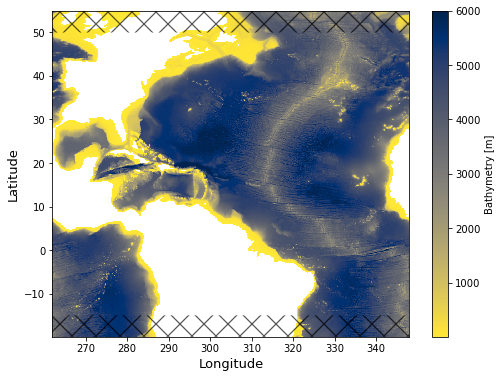

In [84]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.pcolormesh(ds.XC, ds.YC, ds.Depth.where(ds.maskInC!=0.), cmap='cividis_r', rasterized=True)
ax.pcolor(ds.XC, ds.YC, ds.Depth.where(ds.YC>50), hatch='X', alpha=0., rasterized=True)
ax.pcolor(ds.XC, ds.YC, ds.Depth.where(ds.YC<-15), hatch='X', alpha=0., rasterized=True)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"Bathymetry [m]")
ax.set_xlabel('Longitude', fontsize=13)
ax.set_ylabel('Latitude', fontsize=13)
plt.savefig(op.join(savedir,'Figures/Bathymetry.pdf'))

In [11]:
grid = Grid(dsnap, periodic=['X'])
grid

<xgcm.Grid>
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center

In [38]:
# Vol_r = ds.rA**-1 * ds.drF**-1 * ds.hFacC**-1
# xA = ds.hFacW * ds.dyG * ds.drF
# yA = ds.hFacS * ds.dxG * ds.drF
# dxC_r = ds.dxC**-1
# dyC_r = ds.dyC**-1
# dxG_r = ds.dxG**-1
# dyG_r = ds.dyG**-1
# rA_r = ds.rA**-1
fG = xr.apply_ufunc(gsw.f, dsnap.YG, dask='parallelized')
fC = xr.apply_ufunc(gsw.f, dsnap.YC, dask='parallelized')

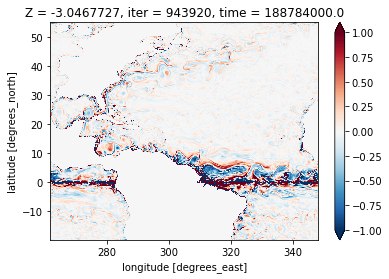

In [15]:
vort = (grid.diff(ds.VVEL*ds.dyC*ds.hFacS,'X')
        - grid.diff(ds.UVEL*ds.dxC*ds.hFacW,'Y',boundary='fill')) * ds.rAz**-1
(vort[0,0]*fG**-1).plot(vmax=1.)

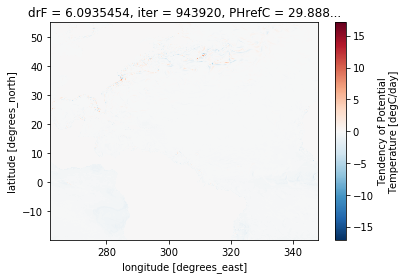

In [14]:
ds.TOTTTEND[0,0].plot()

In [12]:
rho_snap = xr.apply_ufunc(jmd95.densjmd95, dsnap.SALT, dsnap.THETA,
                          (dsnap.PHIHYD-grav*dsnap.Z)*rhoConst*1e-4, # pressure in [dbar]!!!!
                          dask='parallelized', output_dtypes=[float,]
                         ).where(dsnap.maskC!=0.)
rho_snapx = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsnap.SALT,'X'), 
                           grid.interp(dsnap.THETA,'X'), 
                           (grid.interp(dsnap.PHIHYD,'X')-grav*dsnap.Z)*rhoConst*1e-4, 
                           dask='parallelized', output_dtypes=[float,]
                          ).where(dsnap.maskW!=0.)
rho_snapy = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsnap.SALT,'Y',boundary='fill'), 
                           grid.interp(dsnap.THETA,'Y',boundary='fill'), 
                           (grid.interp(dsnap.PHIHYD,'Y',boundary='fill')
                            - grav*dsnap.Z)*rhoConst*1e-4,
                           dask='parallelized', output_dtypes=[float,]
                          ).where(dsnap.maskS!=0.)
# rhoz = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsocn.SALT,'Z',boundary='fill'), 
#                       grid.interp(dsocn.THETA,'Z',boundary='fill'), 
#                       grid.interp((dsocn.PHIHYD-grav*dsocn.Z)*rhoConst*1e-4,'Z',boundary='fill'),
#                       dask='parallelized', output_dtypes=[float]
#                      ).where(dsocn.maskInS!=0.)
rho_snap

<xarray.DataArray (nmemb: 12, Z: 46, YC: 900, XC: 1000)>
dask.array<where, shape=(12, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 900, 250), chunktype=numpy.ndarray>
Coordinates:
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    time     float64 1.888e+08
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    rA       (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11

In [9]:
rho_tave = xr.apply_ufunc(jmd95.densjmd95, dsave.SALT, dsave.THETA,
                          (dsnap.PHIHYD.mean('time')-grav*dsave.Z)*rhoConst*1e-4, # pressure in [dbar]!!!!
                          dask='parallelized', output_dtypes=[float,]
                         ).where(dsave.maskC!=0.)
rho_tavex = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsave.SALT,'X'), 
                           grid.interp(dsave.THETA,'X'), 
                           grid.interp((dsnap.PHIHYD.mean('time')-grav*dsave.Z)*rhoConst*1e-4,'X'), 
                           dask='parallelized', output_dtypes=[float,]
                          ).where(dsave.maskW!=0.)
rho_tavey = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsave.SALT,'Y',boundary='fill'), 
                           grid.interp(dsave.THETA,'Y',boundary='fill'), 
                           grid.interp((dsnap.PHIHYD.mean('time')-grav*dsave.Z)*rhoConst*1e-4,
                                       'Y',boundary='fill'),
                           dask='parallelized', output_dtypes=[float,]
                          ).where(dsave.maskS!=0.)
# rhoz = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsocn.SALT,'Z',boundary='fill'), 
#                       grid.interp(dsocn.THETA,'Z',boundary='fill'), 
#                       grid.interp((dsocn.PHIHYD-grav*dsocn.Z)*rhoConst*1e-4,'Z',boundary='fill'),
#                       dask='parallelized', output_dtypes=[float]
#                      ).where(dsocn.maskInS!=0.)
rho_tave

NameError: name 'grid' is not defined

In [13]:
buoy = -grav * (rho_snap - rhoConst) * rhoConst**-1
# m = ds.PHIHYD.where(ds.maskC!=0.) - buoy*ds.Z

##################
dbdx = (grid.diff(buoy * grid.interp(dsnap.dyG,'X'),
                  'X'
                 ) * dsnap.rAw**-1
       ).where(dsnap.maskW!=0.)
dbdy = (grid.diff(buoy * grid.interp(dsnap.dxG,'Y',boundary='fill'),
                  'Y',boundary='fill'
                 ) * dsnap.rAs**-1
       ).where(dsnap.maskS!=0.)
##################
dpdx_snap = (grid.diff(dsnap.PHIHYD.where(dsnap.maskC!=0.) 
                       * grid.interp(dsnap.dyG,'X'),'X'
                      ) * dsnap.rAw**-1
            ).where(dsnap.maskW!=0.)
dpdy_snap = (grid.diff(dsnap.PHIHYD.where(dsnap.maskC!=0.) 
                       * grid.interp(dsnap.dxG,'Y',boundary='fill'),
                       'Y',boundary='fill'
                      ) * dsnap.rAs**-1
            ).where(dsnap.maskS!=0.)

# dpdx_tave = (grid.diff(dsnap.PHIHYD.mean('time').where(dsnap.maskC!=0.) 
#                        * grid.interp(dsnap.dyG,'X'),'X'
#                       ) * dsnap.rAw**-1
#             ).where(dsnap.maskW!=0.)
# dpdy_tave = (grid.diff(dsnap.PHIHYD.mean('time').where(dsnap.maskC!=0.) 
#                        * grid.interp(dsnap.dxG,'Y',boundary='fill'),
#                        'Y',boundary='fill'
#                       ) * dsnap.rAs**-1
#             ).where(dsnap.maskS!=0.)

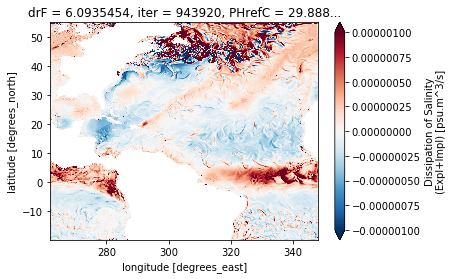

In [16]:
ds.Diss_SLT.where(ds.maskC!=0.)[-1,0].plot(vmax=1e-6)

In [14]:
# DiffE = - (-grid.diff(ds.DFrE_TH,'Z',boundary='fill') * Vol_r
#            + grid.diff(ds.DFxE_TH,'X') * Vol_r
#            + grid.diff(ds.DFyE_TH,'Y',boundary='fill') * Vol_r
#           ).where(ds.maskC!=0.)
# DiffI = (grid.diff(ds.DFrI_TH,'Z',boundary='fill') * Vol_r).where(ds.maskC!=0.)
# Kpp = grid.diff(ds.KPPg_TH.where(ds.maskInC!=0.),'Z',boundary='fill') * Vol_r
swfrac = .62 * np.exp(dsnap.Zl/.6) + (1-.62) * np.exp(dsnap.Zl/20.)
swfrac1 = .62 * np.exp(dsnap.Zl.shift(Zl=-1)/.6) + (1-.62) * np.exp(dsnap.Zl.shift(Zl=-1)/20.)
Qsw = (dsnap.oceQsw / (rhoConst*Cp) / (dsnap.drF*dsnap.hFacC) 
       * (swfrac - swfrac1).data
      ).where(dsnap.maskC!=0.)
Tflx = ((dsnap.TFLUX - dsnap.oceQsw)
        / (rhoConst*Cp*dsnap.drF[0]*dsnap.hFacC.isel(Z=0))
       ).where(dsnap.maskInC!=0.)
tsurf_corr = 0.                  # linFSConverveTr = F.
Surf_corr = (tsurf_corr - dsnap.WTHMASS[:,0].where(dsnap.maskInC!=0.)
            ) / (dsnap.drF[0]*dsnap.hFacC.isel(Z=0))
# print(xr.DataArray((Tflx+Surf_corr).data.reshape((len(ds.nmemb),1,len(ds.YC),len(ds.XC))),
#                    dims=['nmemb','Z','YC','XC'],
#                    coords={'nmemb':ds.nmemb.data,'Z':np.array([ds.Z[0].data]),
#                            'YC':ds.YC.data,'XC':ds.XC.data}))
# DibaT = (ds.Diss_TH.where(ds.maskC!=0.) + Qsw).load()
# DibaT.isel(Z=0)[:] += (Tflx + Surf_corr).load()
DibaT = dsnap.Diss_TH.where(dsnap.maskC!=0.) + Qsw
DibaT = DibaT + xr.concat([xr.DataArray((Tflx+Surf_corr).data.reshape((len(dsnap.nmemb),1,
                                                                       len(dsnap.YC),len(dsnap.XC))),
                                            dims=['nmemb','Z','YC','XC'],
                                            coords={'nmemb':dsnap.nmemb.data,
                                                    'Z':np.array([dsnap.Z[0].data]),
                                                    'YC':dsnap.YC.data,'XC':dsnap.XC.data}),
                               xr.zeros_like(dsnap.Diss_TH.isel(Z=slice(1,None))
                                            ).reset_coords(drop=True)],
                              dim='Z')
# DibaT

# ##################
# DiffE = - (-grid.diff(ds.DFrE_SLT,'Z',boundary='fill') * Vol_r
#            + grid.diff(ds.DFxE_SLT,'X') * Vol_r
#            + grid.diff(ds.DFyE_SLT,'Y',boundary='fill') * Vol_r
#           ).where(ds.maskC!=0.)
# DiffI = (grid.diff(ds.DFrI_SLT,'Z',boundary='fill') * Vol_r).where(ds.maskC!=0.)
# Kpp = grid.diff(ds.KPPg_SLT.where(ds.maskInC!=0.),'Z',boundary='fill') * Vol_r
Sflx = (dsnap.SFLUX
        / (rhoConst*dsnap.drF[0]*dsnap.hFacC.isel(Z=0))
       ).where(dsnap.maskInC!=0.)
ssurf_corr = 0.                  # linFSConverveTr = F.
Surf_corr = (ssurf_corr - dsnap.WSLTMASS[:,0].where(dsnap.maskInC!=0.)
            ) / (dsnap.drF[0]*dsnap.hFacC.isel(Z=0))
DibaS = dsnap.Diss_SLT.where(dsnap.maskC!=0.)
# DibaS.isel(Z=0)[:] += (Sflx + Surf_corr).load()
DibaS = DibaS + xr.concat([xr.DataArray((Sflx+Surf_corr).data.reshape((len(dsnap.nmemb),1,
                                                                       len(dsnap.YC),len(dsnap.XC))),
                                            dims=['nmemb','Z','YC','XC'],
                                            coords={'nmemb':dsnap.nmemb.data,
                                                    'Z':np.array([dsnap.Z[0].data]),
                                                    'YC':dsnap.YC.data,'XC':dsnap.XC.data}),
                               xr.zeros_like(dsnap.Diss_SLT.isel(Z=slice(1,None))
                                            ).reset_coords(drop=True)],
                              dim='Z')

comp = grid.interp(dsnap.WVEL,'Z',boundary='fill').chunk({'Z':-1}) * grav**2 * cs**-2
comp

<xarray.DataArray (nmemb: 12, Z: 46, YC: 900, XC: 1000)>
dask.array<mul, shape=(12, 46, 900, 1000), dtype=float32, chunksize=(1, 46, 900, 250), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    time     float64 1.888e+08
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    rA       (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>

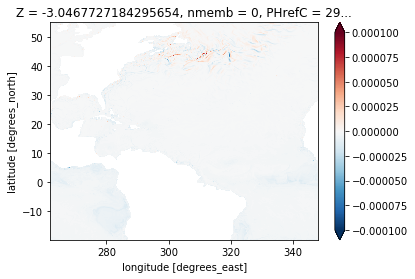

In [18]:
DibaT[0,0].plot(vmax=1e-4)

In [15]:
# drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(dsnap.drF.sel(Z=slice(None,
#                                                                                              None))),
#                                                             np.squeeze(dsnap.drC.sel(Zp1=slice(None,
#                                                                                                None))),
#                                                             10)
fine_drf = np.squeeze(dsnap.drF.sel(Z=slice(None,None)))
fine_drc = np.squeeze(dsnap.drC.sel(Zp1=slice(None,None)))

In [18]:
Dsig = 30
nlayers = 60

siglayers = np.linspace(20,50,nlayers)
func = interp1d(range(1,nlayers+1), siglayers, fill_value='extrapolate')
sigp1layers = func(np.arange(.5,nlayers+1.5,1))
# plt.plot(siglayers, range(81))

43


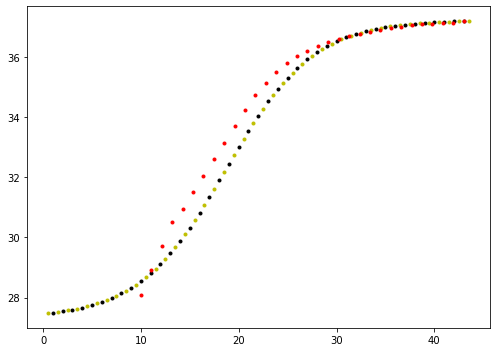

In [16]:
# siglayers = 22. + np.arange(0,10.2,0.2)
# siglayers = np.linspace(25,40,100)
hycomlayers = np.array([28.1, 28.9, 29.7,
                      30.50, 30.95, 31.50, 32.05, 32.60, 33.15, 33.70, 34.25, 34.75,
                      35.15, 35.50, 35.80, 36.04, 36.20, 36.38, 36.52, 36.62, 36.70,
                      36.77, 36.83, 36.89, 36.97, 37.02, 37.06, 37.09, 37.11, 37.13,
                      37.15, 37.20]
                      )
Dsig = 9.7
nlayers = 43
# tmp = np.log(np.linspace(np.exp(1),np.exp(10),101))
# tmp2 = tmp[1:] - tmp[1]
# tmp2 *= tmp2[-1]**-1 * Dsig
# print(tmp2)
tmp = np.tanh(np.linspace(-2.,2.75,nlayers))
tmp += np.abs(tmp.min())
tmp *= tmp.max()**-1 * Dsig
# print(tmp)
siglayers = 27.5 + tmp
func = interp1d(range(1,nlayers+1), siglayers, fill_value='extrapolate')
sigp1layers = func(np.arange(.5,nlayers+1.5,1))
print(len(siglayers))
fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
ax.plot(range(1,nlayers+1), siglayers, 'k.')
ax.plot(np.arange(.5,nlayers+1.5,1), sigp1layers, 'y.')
ax.plot(np.linspace(10,nlayers,32), hycomlayers, 'r.')

In [45]:
zz, _ = xr.broadcast(dsnap.Z, rho_snap.isel(Z=0,nmemb=0).sel(YC=slice(ystart-12**-1,yend+2*12**-1)))
zzy, _ = xr.broadcast(dsnap.Z, rho_snapy.isel(Z=0,nmemb=0).sel(YG=slice(ystart-12**-1,yend+2*12**-1)))
zzx, _ = xr.broadcast(dsnap.Z, rho_snapx.isel(Z=0,nmemb=0).sel(YC=slice(ystart-12**-1,yend+2*12**-1)))
# zz

In [25]:
zdz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                                len(dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                                len(dsnap.XC),len(siglayers))),
                       dims=['nmemb','YC','XC','sig'],
                       coords={'nmemb':range(len(dsnap.nmemb),),
                               'YC':dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                               'XC':dsnap.XC.data,'sig':siglayers}
                       ) * np.nan
dzetaF_snap = zdz_snap.copy() * np.nan

for tt in range(len(dsnap.nmemb)):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(zz).where(dsnap.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                               yend+2*12**-1)),
                          (rho_snap.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                          yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

    tmp2 = xr.apply_ufunc(layers_numpy, 
                          zz.chunk({'XC':xchunk}),
                          (rho_snap.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                          yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    dzetaF_snap[tt] = tmp1.data
    zdz_snap[tt] = tmp2.data

    del tmp1, tmp2


dzetaF_snap = dzetaF_snap.chunk({'nmemb':1,'sig':10,'XC':xchunk})
zdz_snap = zdz_snap.chunk({'nmemb':1,'sig':10,'XC':xchunk})

zdz_snap

<xarray.DataArray (nmemb: 12, YC: 723, XC: 1000, sig: 60)>
dask.array<xarray-<this-array>, shape=(12, 723, 1000, 60), dtype=float64, chunksize=(1, 723, 250, 10), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0

In [26]:
zxdz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                            len(dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                            len(dsnap.XG),len(siglayers))),
                   dims=['nmemb','YC','XG','sig'],
                   coords={'nmemb':range(len(dsnap.nmemb),),
                           'YC':dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                           'XG':dsnap.XG.data,'sig':siglayers}
                   ) * np.nan
dzetaFx_snap = zxdz_snap.copy()


for tt in range(len(dsnap.nmemb)):
    tmp3 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(zzx).chunk({'XG':xchunk}),
                          (rho_snapx.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                           yend+2*12**-1)
                                                                 ).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    

    tmp4 = xr.apply_ufunc(layers_numpy, 
                          zzx.chunk({'XG':xchunk}),
                          (rho_snapx.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                           yend+2*12**-1)
                                                                 ).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    dzetaFx_snap[tt] = tmp3.data
    zxdz_snap[tt] = tmp4.data

    del tmp3, tmp4


dzetaFx_snap = dzetaFx_snap.chunk({'nmemb':1,'sig':10,'XG':xchunk})
zxdz_snap = zxdz_snap.chunk({'nmemb':1,'sig':10,'XG':xchunk})

zxdz_snap

<xarray.DataArray (nmemb: 12, YC: 723, XG: 1000, sig: 60)>
dask.array<xarray-<this-array>, shape=(12, 723, 1000, 60), dtype=float64, chunksize=(1, 723, 250, 10), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0

In [27]:
zydz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                                 len(dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                                 len(dsnap.XC),len(siglayers))),
                        dims=['nmemb','YG','XC','sig'],
                        coords={'nmemb':range(len(dsnap.nmemb),),
                                'YG':dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                                'XC':dsnap.XC.data,'sig':siglayers}
                        ) * np.nan
dzetaFy_snap = zydz_snap.copy()


for tt in range(len(dsnap.nmemb)):
    tmp5 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(zzy).chunk({'XC':xchunk}),
                          (rho_snapy.isel(nmemb=tt)-rhoConst).sel(YG=slice(ystart-12**-1,
                                                                           yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp6 = xr.apply_ufunc(layers_numpy, 
                          zzy.chunk({'XC':xchunk}),
                          (rho_snapy.isel(nmemb=tt)-rhoConst).sel(YG=slice(ystart-12**-1,
                                                                           yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    dzetaFy_snap[tt] = tmp5.data
    zydz_snap[tt] = tmp6.data

    del tmp5, tmp6


dzetaFy_snap = dzetaFy_snap.chunk({'nmemb':1,'sig':10,'XC':xchunk})
zydz_snap = zydz_snap.chunk({'nmemb':1,'sig':10,'XC':xchunk})

zydz_snap

<xarray.DataArray (nmemb: 12, YG: 723, XC: 1000, sig: 60)>
dask.array<xarray-<this-array>, shape=(12, 723, 1000, 60), dtype=float64, chunksize=(1, 723, 250, 10), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * YG       (YG) >f4 -10.041633 -9.9583 -9.874967 ... 50.041702 50.125034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0

In [34]:
pdz = zdz.load().copy() * np.nan
bdz = zdz.load().copy() * np.nan


for tt in range(len(ds.nmemb)):
    while os.access(op.join(ddir,'grid_chaO/gridMIT_update1/'), 
                    os.R_OK) is False or os.access(op.join(ddir,'qjamet/RUNS/ORAR/'), os.R_OK) is False:
        time.sleep(1)
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          ds.PHIHYD.isel(nmemb=tt).where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                    yend+2*12**-1)),
                          (rho_insitu.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                            yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    while os.access(op.join(ddir,'grid_chaO/gridMIT_update1/'), 
                    os.R_OK) is False or os.access(op.join(ddir,'qjamet/RUNS/ORAR/'), os.R_OK) is False:
        time.sleep(1)
    tmp2 = xr.apply_ufunc(layers_numpy, 
                          buoy.isel(nmemb=tt).where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                               yend+2*12**-1)),
                          (rho_insitu.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                            yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

        
    pdz[tt] = tmp1.data
    bdz[tt] = tmp2.data
    
    del tmp1, tmp2


pdz = pdz.chunk({'nmemb':1,'sig':1})
bdz = bdz.chunk({'nmemb':1,'sig':1})

pdz

<xarray.DataArray (nmemb: 5, YC: 723, XC: 1000, sig: 81)>
dask.array<xarray-<this-array>, shape=(5, 723, 1000, 81), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.38 20.75 21.12 ... 48.88 49.25 49.62 50.0

In [16]:
year = 1963
itime = 943920
dsz = xr.open_dataset(op.join(savedir,'%4d/Zs_membs_%010d.nc' 
                              % (year,itime)),
                      chunks={'nmemb':1,'XC':xchunk,'XG':xchunk}
                     )
dsz

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 783, YG: 783, nmemb: 12, sig: 60, sigp1: 61)
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * YC       (YC) float32 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0
  * YG       (YG) float32 -15.041634 -14.9583 -14.874967 ... 50.041702 50.125034
  * XG       (XG) float32 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sigp1    (sigp1) float64 19.75 20.25 20.76 21.27 ... 48.73 49.24 49.75 50.25
Data variables:
    zdz      (nmemb, YC, XC, sig) float64 dask.array<chunksize=(1, 783, 250, 60), meta=np.ndarray>
    zydz     (nmemb, YG, XC, sig) float64 dask.array<chunksize=(1, 783, 250, 60), meta=np.ndarray>
    zxdz     (nmemb, YC, XG, sig) float64 dask.array<chunksize=(1, 783, 250, 60), meta=np.ndarray>
    dzetaF   (nmemb, YC, XC, sig) float64 dask.array<chunksize=(1, 783, 250, 60), meta=np.ndarray>
    dzetaFx  (nmemb, YC, XG, sig) float64 dask.array<chunksize=(1, 783, 250, 60), meta=np.ndarray>
    dzetaFy  (nmemb, YG, XC, sig) float64 dask.array<chunksize=(1, 783, 250, 60), meta=np.ndarray>
    dzetaFz  (nmemb, YG, XG, sig) float64 dask.array<chunksize=(1, 783, 250, 60), meta=np.ndarray>

In [19]:
# diaTdz = xr.DataArray(np.ones((len(dsnap.nmemb),
#                                 len(dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
#                                 len(dsnap.XC),len(siglayers))),
#                        dims=['nmemb','YC','XC','sig'],
#                        coords={'nmemb':range(len(dsnap.nmemb),),
#                                'YC':dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
#                                'XC':dsnap.XC.data,'sig':siglayers}
#                        ) * np.nan
# diaSdz = diaTdz.copy() * np.nan


# for tt in range(len(dsnap.nmemb)):
#     tmp3 = xr.apply_ufunc(layers_numpy, 
#                           DibaT.isel(nmemb=tt).where(dsnap.maskC!=0.).sel(YC=slice(ystart-12**-1,
#                                                                                    yend+2*12**-1)
#                                                                          ).chunk({'XC':xchunk,'Z':-1}),
#                           (rho_snap.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
#                           kwargs={'thetalayers':siglayers,'mapfact':mapfact,
#                                   'mapindex':mapindex,'cellindex':cellindex,
#                                   'drf_finer':drf_finer},
#                           dask='parallelized',
#                           input_core_dims=[['Z'],['Z']], 
#                           output_core_dims=[['sig']],
#                           output_dtypes=[float,], output_sizes={'sig':siglayers.size}
#                          ).compute()
    
#     tmp4 = xr.apply_ufunc(layers_numpy,
#                           DibaS.isel(nmemb=tt).where(dsnap.maskC!=0.).sel(YC=slice(ystart-12**-1,
#                                                                                    yend+2*12**-1)
#                                                                          ).chunk({'XC':xchunk,'Z':-1}),
#                           (rho_snap.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
#                           kwargs={'thetalayers':siglayers,'mapfact':mapfact,
#                                   'mapindex':mapindex,'cellindex':cellindex,
#                                   'drf_finer':drf_finer},
#                           dask='parallelized',
#                           input_core_dims=[['Z'],['Z']], 
#                           output_core_dims=[['sig']],
#                           output_dtypes=[float,], output_sizes={'sig':siglayers.size}
#                          ).compute()
    
        
#     diaTdz[tt] = tmp3.data
#     diaSdz[tt] = tmp4.data
    
#     del tmp3, tmp4

diaTdz = layers_apply(DibaT.where(dsnap.maskC!=0.).sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
                                                      ).chunk({'nmemb':membchunk,'Z':-1,
                                                               'XC':xchunk}),
                      (rho_snap.sel(YC=slice(yNstart-12**-1,yend+2*12**-1))-rhoConst),
                      siglayers, fine_drf, fine_drc, fine_fact=nremap,
                      lev_name='Z', Tlev_name='sig').compute()
diaSdz = layers_apply(DibaS.where(dsnap.maskC!=0.).sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
                                                      ).chunk({'nmemb':membchunk,'Z':-1,
                                                               'XC':xchunk}),
                      (rho_snap.sel(YC=slice(yNstart-12**-1,yend+2*12**-1))-rhoConst),
                      siglayers, fine_drf, fine_drc, fine_fact=nremap,
                      lev_name='Z', Tlev_name='sig').compute()
drdTdz = layers_apply(rho_th.where(dsnap.maskC!=0.).sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
                                                       ).chunk({'nmemb':membchunk,'XC':xchunk}),
                      (rho_snap.sel(YC=slice(yNstart-12**-1,yend+2*12**-1))-rhoConst),
                      siglayers, fine_drf, fine_drc, fine_fact=nremap,
                      lev_name='Z', Tlev_name='sig').compute()
drdsdz = layers_apply(rho_s.where(dsnap.maskC!=0.).sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
                                                      ).chunk({'nmemb':membchunk,'XC':xchunk}),
                      (rho_snap.sel(YC=slice(yNstart-12**-1,yend+2*12**-1))-rhoConst),
                      siglayers, fine_drf, fine_drc, fine_fact=nremap,
                      lev_name='Z', Tlev_name='sig').compute()
cmpdz = layers_apply(comp.where(dsnap.maskC!=0.).sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
                                                    ).chunk({'nmemb':membchunk,'XC':xchunk}),
                     (rho_snap.sel(YC=slice(yNstart-12**-1,yend+2*12**-1))-rhoConst),
                     siglayers, fine_drf, fine_drc, fine_fact=nremap,
                     lev_name='Z', Tlev_name='sig').compute()


diaTdz = diaTdz.chunk({'nmemb':membchunk,'sig':10,'XC':xchunk})
diaSdz = diaSdz.chunk({'nmemb':membchunk,'sig':10,'XC':xchunk})
drdTdz = drdTdz.chunk({'nmemb':membchunk,'sig':10,'XC':xchunk})
drdsdz = drdsdz.chunk({'nmemb':membchunk,'sig':10,'XC':xchunk})
cmpdz = cmpdz.chunk({'nmemb':membchunk,'sig':10,'XC':xchunk})

In [20]:
# sdz = xr.DataArray(np.ones((len(dsnap.nmemb),
#                                 len(dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
#                                 len(dsnap.XC),len(siglayers))),
#                        dims=['nmemb','YC','XC','sig'],
#                        coords={'nmemb':range(len(dsnap.nmemb),),
#                                'YC':dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
#                                'XC':dsnap.XC.data,'sig':siglayers}
#                        ) * np.nan
# tdz = sdz.copy() * np.nan


# for tt in range(len(dsnap.nmemb)):
#     tmp5 = xr.apply_ufunc(layers_numpy, 
#                           dsnap.THETA.isel(nmemb=tt
#                                           ).where(dsnap.maskC!=0.).sel(YC=slice(ystart-12**-1,
#                                                                                 yend+2*12**-1)
#                                                                       ).chunk({'XC':xchunk}),
#                           (rho_snap.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
#                           kwargs={'thetalayers':siglayers,'mapfact':mapfact,
#                                   'mapindex':mapindex,'cellindex':cellindex,
#                                   'drf_finer':drf_finer},
#                           dask='parallelized',
#                           input_core_dims=[['Z'],['Z']], 
#                           output_core_dims=[['sig']],
#                           output_dtypes=[float,], output_sizes={'sig':siglayers.size}
#                          ).compute()
    
#     tmp6 = xr.apply_ufunc(layers_numpy, 
#                           dsnap.SALT.isel(nmemb=tt
#                                          ).where(dsnap.maskC!=0.).sel(YC=slice(ystart-12**-1,
#                                                                                yend+2*12**-1)
#                                                                      ).chunk({'XC':xchunk}),
#                           (rho_snap.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
#                           kwargs={'thetalayers':siglayers,'mapfact':mapfact,
#                                   'mapindex':mapindex,'cellindex':cellindex,
#                                   'drf_finer':drf_finer},
#                           dask='parallelized',
#                           input_core_dims=[['Z'],['Z']], 
#                           output_core_dims=[['sig']],
#                           output_dtypes=[float,], output_sizes={'sig':siglayers.size}
#                          ).compute()

        
#     tdz[tt] = tmp5.data
#     sdz[tt] = tmp6.data
    
#     del tmp5, tmp6

tdz = layers_apply(dsnap.THETA.where(dsnap.maskC!=0.).sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
                                                         ).chunk({'nmemb':membchunk,'Z':-1,
                                                                  'XC':xchunk}),
                   (rho_snap.sel(YC=slice(yNstart-12**-1,yend+2*12**-1))-rhoConst),
                   siglayers, fine_drf, fine_drc, fine_fact=nremap,
                   lev_name='Z', Tlev_name='sig').compute()
sdz = layers_apply(dsnap.SALT.where(dsnap.maskC!=0.).sel(YC=slice(yNstart-12**-1,yend+2*12**-1)
                                                        ).chunk({'nmemb':membchunk,'Z':-1,
                                                                 'XC':xchunk}),
                   (rho_snap.sel(YC=slice(yNstart-12**-1,yend+2*12**-1))-rhoConst),
                   siglayers, fine_drf, fine_drc, fine_fact=nremap,
                   lev_name='Z', Tlev_name='sig').compute()


tdz = tdz.chunk({'nmemb':1,'sig':10,'XC':xchunk})
sdz = sdz.chunk({'nmemb':1,'sig':10,'XC':xchunk})

In [30]:
pxdz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                                 len(dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                                 len(dsnap.XG),len(siglayers))),
                        dims=['nmemb','YC','XG','sig'],
                        coords={'nmemb':range(len(dsnap.nmemb),),
                                'YC':dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                                'XG':dsnap.XG.data,'sig':siglayers}
                        ) * np.nan
pydz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                                 len(dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                                 len(dsnap.XC),len(siglayers))),
                        dims=['nmemb','YG','XC','sig'],
                        coords={'nmemb':range(len(dsnap.nmemb),),
                                'YG':dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                                'XC':dsnap.XC.data,'sig':siglayers}
                        ) * np.nan


for tt in range(len(dsnap.nmemb)):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          dpdx_snap.isel(nmemb=tt).sel(YC=slice(ystart-12**-1,
                                                                yend+2*12**-1)
                                                      ).chunk({'XG':xchunk}),
                          (rho_snapx.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                           yend+2*12**-1)
                                                                 ).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp2 = xr.apply_ufunc(layers_numpy, 
                          dpdy_snap.isel(nmemb=tt).sel(YG=slice(ystart-12**-1,
                                                                yend+2*12**-1)),
                          (rho_snapy.isel(nmemb=tt)-rhoConst).sel(YG=slice(ystart-12**-1,
                                                                           yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    pxdz_snap[tt] = tmp1
    pydz_snap[tt] = tmp2
    
    del tmp1, tmp2

    
pxdz_snap = pxdz_snap.chunk({'nmemb':1,'sig':10,'XG':xchunk})
pydz_snap = pydz_snap.chunk({'nmemb':1,'sig':10,'XC':xchunk})

In [39]:
bxdz = pxdz.load().copy()*np.nan
bydz = pydz.load().copy()*np.nan

for tt in range(2):
    while os.access(op.join(ddir,'grid_chaO/gridMIT_update1/'), 
                    os.R_OK) is False or os.access(op.join(ddir,'qjamet/RUNS/ORAR/'), os.R_OK) is False:
        time.sleep(1)
    tmp3 = xr.apply_ufunc(layers_numpy, 
                          dbdx[tt].sel(YC=slice(ystart-12**-1,
                                                yend+2*12**-1)).chunk({'XG':xchunk}),
                          (rhox[tt]-rhoConst).sel(YC=slice(ystart-12**-1,
                                                           yend+2*12**-1)).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    while os.access(op.join(ddir,'grid_chaO/gridMIT_update1/'), 
                    os.R_OK) is False or os.access(op.join(ddir,'qjamet/RUNS/ORAR/'), os.R_OK) is False:
        time.sleep(1)
    tmp4 = xr.apply_ufunc(layers_numpy, 
                          dbdy[tt].sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          (rhoy[tt]-rhoConst).sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    bxdz[tt] = tmp3
    bydz[tt] = tmp4
    
    del tmp3, tmp4

    
bxdz = bxdz.chunk({'nmemb':1,'sig':1})
bydz = bydz.chunk({'nmemb':1,'sig':1})

In [31]:
udz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                                len(dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                                len(dsnap.XG),len(siglayers))),
                       dims=['nmemb','YC','XG','sig'],
                       coords={'nmemb':range(len(dsnap.nmemb),),
                               'YC':dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                               'XG':dsnap.XG.data,'sig':siglayers}
                       ) * np.nan
vdz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                                len(dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                                len(dsnap.XC),len(siglayers))),
                       dims=['nmemb','YG','XC','sig'],
                       coords={'nmemb':range(len(dsnap.nmemb),),
                               'YG':dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                               'XC':dsnap.XC.data,'sig':siglayers}
                       ) * np.nan

for tt in range(len(dsnap.nmemb)):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          dsnap.UVEL.isel(nmemb=tt).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          (rho_snapx.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                yend+2*12**-1)
                                                      ).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp2 = xr.apply_ufunc(layers_numpy, 
                          dsnap.VVEL.isel(nmemb=tt).sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          (rho_snapy.isel(nmemb=tt)-rhoConst).sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    udz_snap[tt] = tmp1
    vdz_snap[tt] = tmp2

    
    del tmp1, tmp2

    
udz_snap = udz_snap.chunk({'nmemb':1,'sig':10,'XG':xchunk})
vdz_snap = vdz_snap.chunk({'nmemb':1,'sig':10,'XC':xchunk})

In [23]:
zz, _ = xr.broadcast(dsave.Z, rho_tave.isel(Z=0,nmemb=0).sel(YC=slice(ystart-12**-1,yend+2*12**-1)))
zzy, _ = xr.broadcast(dsave.Z, rho_tavey.isel(Z=0,nmemb=0).sel(YG=slice(ystart-12**-1,yend+2*12**-1)))
zzx, _ = xr.broadcast(dsave.Z, rho_tavex.isel(Z=0,nmemb=0).sel(YC=slice(ystart-12**-1,yend+2*12**-1)))

In [24]:
zdz_tave = xr.DataArray(np.ones((len(dsave.nmemb),
                                len(dsave.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                                len(dsave.XC),len(siglayers))),
                       dims=['nmemb','YC','XC','sig'],
                       coords={'nmemb':range(len(dsave.nmemb),),
                               'YC':dsave.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                               'XC':dsave.XC.data,'sig':siglayers}
                       ) * np.nan
dzetaF_tave = zdz_tave.copy() * np.nan

for tt in range(len(dsave.nmemb)):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(zz).where(dsave.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                               yend+2*12**-1)),
                          (rho_tave.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                          yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

    tmp2 = xr.apply_ufunc(layers_numpy, 
                          zz.chunk({'XC':xchunk}),
                          (rho_tave.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                          yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    dzetaF_tave[tt] = tmp1.data
    zdz_tave[tt] = tmp2.data

    del tmp1, tmp2


dzetaF_tave = dzetaF_tave.chunk({'nmemb':1,'sig':10,'XC':xchunk})
zdz_tave = zdz_tave.chunk({'nmemb':1,'sig':10,'XC':xchunk})

zdz_tave

<xarray.DataArray (nmemb: 6, YC: 723, XC: 1000, sig: 60)>
dask.array<xarray-<this-array>, shape=(6, 723, 1000, 60), dtype=float64, chunksize=(1, 723, 250, 10), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0

In [25]:
zxdz_tave = xr.DataArray(np.ones((len(dsave.nmemb),
                            len(dsave.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                            len(dsave.XG),len(siglayers))),
                   dims=['nmemb','YC','XG','sig'],
                   coords={'nmemb':range(len(dsave.nmemb),),
                           'YC':dsave.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                           'XG':dsave.XG.data,'sig':siglayers}
                   ) * np.nan
dzetaFx_tave = zxdz_tave.copy()


for tt in range(len(dsave.nmemb)):
    tmp3 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(zzx).chunk({'XG':xchunk}),
                          (rho_tavex.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                           yend+2*12**-1)
                                                                 ).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    

    tmp4 = xr.apply_ufunc(layers_numpy, 
                          zzx.chunk({'XG':xchunk}),
                          (rho_tavex.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                           yend+2*12**-1)
                                                                 ).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    dzetaFx_tave[tt] = tmp3.data
    zxdz_tave[tt] = tmp4.data

    del tmp3, tmp4


dzetaFx_tave = dzetaFx_tave.chunk({'nmemb':1,'sig':10,'XG':xchunk})
zxdz_tave = zxdz_tave.chunk({'nmemb':1,'sig':10,'XG':xchunk})

zxdz_tave

<xarray.DataArray (nmemb: 6, YC: 723, XG: 1000, sig: 60)>
dask.array<xarray-<this-array>, shape=(6, 723, 1000, 60), dtype=float64, chunksize=(1, 723, 250, 10), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0

In [26]:
zydz_tave = xr.DataArray(np.ones((len(dsave.nmemb),
                                 len(dsave.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                                 len(dsave.XC),len(siglayers))),
                        dims=['nmemb','YG','XC','sig'],
                        coords={'nmemb':range(len(dsave.nmemb),),
                                'YG':dsave.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                                'XC':dsave.XC.data,'sig':siglayers}
                        ) * np.nan
dzetaFy_tave = zydz_tave.copy()


for tt in range(len(dsave.nmemb)):
    tmp5 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(zzy).chunk({'XC':xchunk}),
                          (rho_tavey.isel(nmemb=tt)-rhoConst).sel(YG=slice(ystart-12**-1,
                                                                           yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp6 = xr.apply_ufunc(layers_numpy, 
                          zzy.chunk({'XC':xchunk}),
                          (rho_tavey.isel(nmemb=tt)-rhoConst).sel(YG=slice(ystart-12**-1,
                                                                           yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    dzetaFy_tave[tt] = tmp5.data
    zydz_tave[tt] = tmp6.data

    del tmp5, tmp6


dzetaFy_tave = dzetaFy_tave.chunk({'nmemb':1,'sig':10,'XC':xchunk})
zydz_tave = zydz_tave.chunk({'nmemb':1,'sig':10,'XC':xchunk})

zydz_tave

<xarray.DataArray (nmemb: 6, YG: 723, XC: 1000, sig: 60)>
dask.array<xarray-<this-array>, shape=(6, 723, 1000, 60), dtype=float64, chunksize=(1, 723, 250, 10), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5
  * YG       (YG) >f4 -10.041633 -9.9583 -9.874967 ... 50.041702 50.125034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0

In [27]:
udz_tave = xr.DataArray(np.ones((len(dsave.nmemb),
                                len(dsave.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                                len(dsave.XG),len(siglayers))),
                       dims=['nmemb','YC','XG','sig'],
                       coords={'nmemb':range(len(dsave.nmemb),),
                               'YC':dsave.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                               'XG':dsave.XG.data,'sig':siglayers}
                       ) * np.nan
vdz_tave = xr.DataArray(np.ones((len(dsave.nmemb),
                                len(dsave.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                                len(dsave.XC),len(siglayers))),
                       dims=['nmemb','YG','XC','sig'],
                       coords={'nmemb':range(len(dsave.nmemb),),
                               'YG':dsave.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                               'XC':dsave.XC.data,'sig':siglayers}
                       ) * np.nan

for tt in range(len(dsave.nmemb)):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          dsave.UVEL[tt].sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          (rho_tavex[tt]-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                yend+2*12**-1)
                                                      ).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp2 = xr.apply_ufunc(layers_numpy, 
                          dsave.VVEL[tt].sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          (rho_tavey[tt]-rhoConst).sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    udz_tave[tt] = tmp1
    vdz_tave[tt] = tmp2

    del tmp1, tmp2

    
udz_tave = udz_tave.chunk({'nmemb':1,'sig':10,'XG':xchunk})
vdz_tave = vdz_tave.chunk({'nmemb':1,'sig':10,'XC':xchunk})

In [28]:
pxdz_tave = xr.DataArray(np.ones((len(dsave.nmemb),
                                len(dsave.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                                len(dsave.XG),len(siglayers))),
                       dims=['nmemb','YC','XG','sig'],
                       coords={'nmemb':range(len(dsave.nmemb),),
                               'YC':dsave.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                               'XG':dsave.XG.data,'sig':siglayers}
                        ) * np.nan
pydz_tave = xr.DataArray(np.ones((len(dsave.nmemb),
                                len(dsave.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                                len(dsave.XC),len(siglayers))),
                       dims=['nmemb','YG','XC','sig'],
                       coords={'nmemb':range(len(dsave.nmemb),),
                               'YG':dsave.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                               'XC':dsave.XC.data,'sig':siglayers}
                        ) * np.nan


for tt in range(len(dsave.nmemb)):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          dpdx_tave[tt].sel(YC=slice(ystart-12**-1,
                                                     yend+2*12**-1)
                                           ).chunk({'XG':xchunk}),
                          (rho_tavex[tt]-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                yend+2*12**-1)
                                                      ).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp2 = xr.apply_ufunc(layers_numpy, 
                          dpdy_tave[tt].sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          (rho_tavey[tt]-rhoConst).sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    pxdz_tave[tt] = tmp1
    pydz_tave[tt] = tmp2
    
    del tmp1, tmp2

    
pxdz_tave = pxdz_tave.chunk({'nmemb':1,'sig':10,'XG':xchunk})
pydz_tave = pydz_tave.chunk({'nmemb':1,'sig':10,'XC':xchunk})

In [42]:
dssig = zdz_snap.to_dataset(name='zdz')
# dssig['udz'] = udz
# dssig['vdz'] = vdz
dssig.coords['YG'] = ('YG',dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data)
dssig.coords['XG'] = ('XG',dsnap.XG.data)
dssig.coords['sigp1'] = ('sigp1',sigp1layers)
dssig

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 723, YG: 723, nmemb: 12, sig: 60, sigp1: 61)
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0
  * YG       (YG) >f4 -10.041633 -9.9583 -9.874967 ... 50.041702 50.125034
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sigp1    (sigp1) float64 19.75 20.25 20.76 21.27 ... 48.73 49.24 49.75 50.25
Data variables:
    zdz      (nmemb, YC, XC, sig) float64 dask.array<chunksize=(1, 723, 250, 10), meta=np.ndarray>

In [21]:
grids = Grid(dsz.sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                     YG=slice(ystart-12**-1,yend+2*12**-1)), periodic=['X'], 
             coords={'Z':{'center':'sig','outer':'sigp1'},
                     'Y':{'center':'YC','left':'YG'},
                     'X':{'center':'XC','left':'XG'}}
            )
grids

<xgcm.Grid>
Z Axis (not periodic):
  * center   sig --> outer
  * outer    sigp1 --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center

In [22]:
buoyb = -grav * dsz.sig * rhoConst**-1
buoybp1 = -grav * dsz.sigp1 * rhoConst**-1
# sigma_snap = dzetaF_snap * -grids.diff(buoybp1,'Z',boundary='fill')**-1
# sigmay_snap = dzetaFy_snap * -grids.diff(buoybp1,'Z',boundary='fill')**-1
# sigmax_snap = dzetaFx_snap * -grids.diff(buoybp1,'Z',boundary='fill')**-1

# sigma_tave = dzetaF_tave * -grids.diff(buoybp1,'Z',boundary='fill')**-1
# sigmay_tave = dzetaFy_tave * -grids.diff(buoybp1,'Z',boundary='fill')**-1
# sigmax_tave = dzetaFx_tave * -grids.diff(buoybp1,'Z',boundary='fill')**-1
# sigma_snap

In [31]:
# dbdT = grids.diff(tdz*dzetaF_snap**-1,'Z',boundary='fill')**-1 * grids.diff(buoyb,'Z',boundary='fill')
# dbds = grids.diff(sdz*dzetaF_snap**-1,'Z',boundary='fill')**-1 * grids.diff(buoyb,'Z',boundary='fill')
# varpidz = (grids.interp(dbdT,'Z',boundary='fill') * diaTdz
#            + grids.interp(dbds,'Z',boundary='fill') * diaSdz
#           )
# _dT = -grids.diff(tdz * dsz.dzetaF**-1,'Z',boundary='fill')**-1
# _ds = -grids.diff(sdz * dsz.dzetaF**-1,'Z',boundary='fill')**-1
# varpidz_db = (grids.interp(_dT,'Z',boundary='fill') * diaTdz
#               + grids.interp(_ds,'Z',boundary='fill') * diaSdz
#              )
varpidzdr = (drdTdz*diaTdz + drdsdz*diaSdz) * dsz.dzetaF**-1
varpidz = (-varpidzdr * grav*rhoConst**-1 
           + cmpdz
          )
varpidz

<xarray.DataArray (nmemb: 12, YC: 423, XC: 1000, sig: 60)>
dask.array<add, shape=(12, 423, 1000, 60), dtype=float64, chunksize=(1, 423, 250, 10), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 14.92 15.0 15.08 15.17 ... 49.83 49.92 50.0 50.08
    time     float64 1.888e+08
    maskInC  (YC, XC) bool dask.array<chunksize=(423, 250), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(423, 250), meta=np.ndarray>
    iter     int64 943920
    rA       (YC, XC) >f4 dask.array<chunksize=(423, 250), meta=np.ndarray>
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


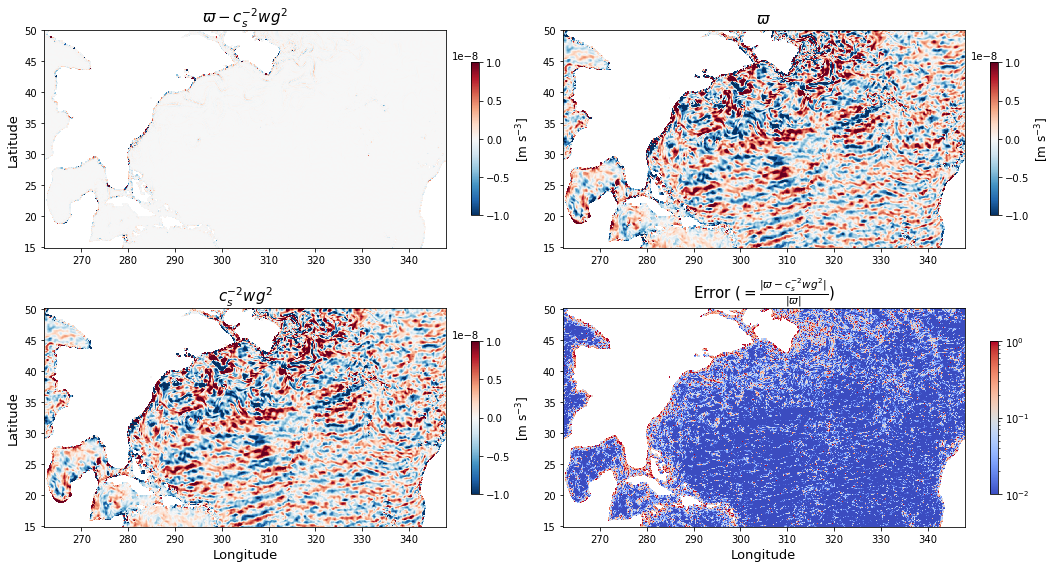

In [34]:
fig, axes = plt.subplots(figsize=(15,8), nrows=2, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)),
                           (-varpidzdr * grav*rhoConst**-1 * dsz.dzetaF**-1
                           ).isel(nmemb=0,sig=16),
                           vmin=-1e-8, vmax=1e-8, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)),
                           (varpidz*dsz.dzetaF**-1).isel(nmemb=0,sig=16),
                           vmin=-1e-8, vmax=1e-8, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)),
                           (cmpdz*dsz.dzetaF**-1).isel(nmemb=0,sig=16), 
                           vmin=-1e-8, vmax=1e-8, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YC.sel(YC=slice(yNstart-12**-1,yend+2*12**-1)),
                           (np.abs(-varpidzdr * grav*rhoConst**-1 
                                   * dsz.dzetaF**-1).isel(nmemb=0,sig=16)
                            * np.abs(varpidz*dsz.dzetaF**-1).isel(nmemb=0,sig=16)**-1), 
                           cmap='coolwarm', rasterized=True,
                           norm=clr.LogNorm(vmin=1e-2, vmax=1e0))


axes[0,0].set_title(r"$\varpi - c_s^{-2}wg^2$", fontsize=15)
axes[0,1].set_title(r"$\varpi$", fontsize=15)
axes[1,0].set_title(r"$c_s^{-2}wg^2$", fontsize=15)
axes[1,1].set_title(r"Error $(=\frac{|\varpi - c_s^{-2}wg^2|}{|\varpi|})$", 
                    fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
cbar0.set_label(r"[m s$^{-3}$]", fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
cbar1.set_label(r"[m s$^{-3}$]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m s$^{-3}$]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
# cbar3.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(savedir,'Figures/Varpi-errors_1963-Dec-26.pdf'))

In [91]:
print(buoyb[0], buoyb[-1])

<xarray.DataArray 'sig' ()>
array(-0.19623925)
Coordinates:
    sig      float64 20.0 <xarray.DataArray 'sig' ()>
array(-0.49059812)
Coordinates:
    sig      float64 50.0


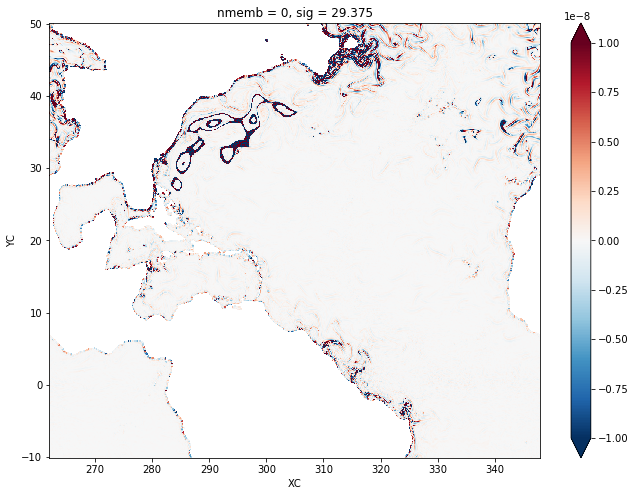

In [44]:
varpi[0,:,:,25].plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r', figsize=(11,8))

In [40]:
# mbx = (mxdz + bxdz*zxdz*dzetaFx**-1) * dzetaFx**-1
# mby = (mydz + bydz*zydz*dzetaFy**-1) * dzetaFy**-1
mbx = pxdz_snap * dzetaFx_snap**-1
mby = pydz_snap * dzetaFy_snap**-1
mbxp_snap = mbx - mbx.mean('nmemb',skipna=True)
mbyp_snap = mby - mby.mean('nmemb',skipna=True)
# mbx = pxdz_tave * dzetaFx_tave**-1
# mby = pydz_tave * dzetaFy_tave**-1
# mbxp_tave = mbx - mbx.mean('nmemb')
# mbyp_tave = mby - mby.mean('nmemb')

# vhat_snap = ((vdz_snap * -grids.diff(buoybp1,
#                                      'Z',boundary='fill')**-1
#              ).mean('nmemb') # vdz * db**-1 = v * dz/db = v * \sigma
#              * sigmay_snap.mean('nmemb')**-1
#             )
# uhat_snap = ((udz_snap * -grids.diff(buoybp1,'Z',boundary='fill')**-1).mean('nmemb') 
#              * sigmax_snap.mean('nmemb')**-1
#             )
vhat_snap = (vdz_snap.mean('nmemb',skipna=True) 
             * dzetaFy_snap.mean('nmemb',skipna=True)**-1)
uhat_snap = (udz_snap.mean('nmemb',skipna=True) 
             * dzetaFx_snap.mean('nmemb',skipna=True)**-1)

vpp_snap = vdz_snap*dzetaFy_snap**-1 - vhat_snap
upp_snap = udz_snap*dzetaFx_snap**-1 - uhat_snap


# vhat_tave = ((vdz_tave * -grids.diff(buoybp1,
#                                      'Z',boundary='fill')**-1
#              ).mean('nmemb') # vdz * db**-1 = v * dz/db = v * \sigma
#              * sigmay_tave.mean('nmemb')**-1
#             )
# uhat_tave = ((udz_tave * -grids.diff(buoybp1,'Z',boundary='fill')**-1).mean('nmemb') 
#              * sigmax_tave.mean('nmemb')**-1
#             )

# vpp_tave = vdz_tave*dzetaFy_tave**-1 - vhat_tave
# upp_tave = udz_tave*dzetaFx_tave**-1 - uhat_tave

print(upp_snap, vpp_snap)

<xarray.DataArray (nmemb: 12, YC: 723, XG: 1000, sig: 60)>
dask.array<sub, shape=(12, 723, 1000, 60), dtype=float64, chunksize=(1, 723, 250, 10), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0 <xarray.DataArray (nmemb: 12, YG: 723, XC: 1000, sig: 60)>
dask.array<sub, shape=(12, 723, 1000, 60), dtype=float64, chunksize=(1, 723, 250, 10), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * YG       (YG) >f4 -10.041633 -9.9583 -9.874967 ... 50.041702 50.125034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0


In [47]:
# varpihat = ((varpi * sigma_snap).mean('nmemb',skipna=True) 
#             * sigma_snap.mean('nmemb',skipna=True)**-1)
# varpipp = (varpi - varpihat)
varpihat = ((varpidz_db * -grids.diff(buoybp1,'Z',boundary='fill')
            ).mean('nmemb',skipna=True) 
            * dzetaF_snap.mean('nmemb',skipna=True)**-1)
varpipp = (varpidz_db*dzetaF_snap**-1
           * -grids.diff(buoybp1,'Z',boundary='fill') - varpihat)

print(varpipp)

<xarray.DataArray (nmemb: 12, YC: 723, XC: 1000, sig: 60)>
dask.array<sub, shape=(12, 723, 1000, 60), dtype=float64, chunksize=(1, 723, 250, 8), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0


In [48]:
zetab = (zdz_snap*dzetaF_snap**-1).mean('nmemb',skipna=True)
zetaxb = (zxdz_snap*dzetaFx_snap**-1).mean('nmemb',skipna=True)
zetayb = (zydz_snap*dzetaFy_snap**-1).mean('nmemb',skipna=True)

zetap_snap = (zdz_snap*dzetaF_snap**-1 - zetab) 
zetayp_snap = (zydz_snap*dzetaFy_snap**-1 - zetayb)
zetaxp_snap = (zxdz_snap*dzetaFx_snap**-1 - zetaxb)

# zetap_tave = (zdz_tave*dzetaF_tave**-1 - (zdz_tave*dzetaF_tave**-1).mean('nmemb')) 
# zetayp_tave = (zydz_tave*dzetaFy_tave**-1 - (zydz_tave*dzetaFy_tave**-1).mean('nmemb'))
# zetaxp_tave = (zxdz_tave*dzetaFx_tave**-1 - (zxdz_tave*dzetaFx_tave**-1).mean('nmemb'))

In [30]:
dudx_snap = grids.diff(uhat_snap*dsnap.dyG,'X') * dsnap.rA**-1
dvdy_snap = grids.diff(vhat_snap*dsnap.dxG,'Y',boundary='fill') * dsnap.rA**-1
dvdx_snap = grids.diff(vhat_snap*dsnap.dyC,'X') * dsnap.rAz**-1
dudy_snap = grids.diff(uhat_snap*dsnap.dxC,'Y',boundary='fill') * dsnap.rAz**-1
# dudx_tave = grids.diff(uhat_tave*dsave.dyG,'X') * dsave.rA**-1
# dvdy_tave = grids.diff(vhat_tave*dsave.dxG,'Y',boundary='fill') * dsave.rA**-1
# dwdz = -(dudx+dvdy)
# whash = grids.cumsum(-dwdz*grids.diff(buoybp1,'Z',boundary='fill'),'Z',boundary='fill')
# whash
dvdx_snap

<xarray.DataArray (YG: 723, XG: 1000, sig: 60)>
dask.array<mul, shape=(723, 1000, 60), dtype=float64, chunksize=(723, 249, 10), chunktype=numpy.ndarray>
Coordinates:
  * YG       (YG) float64 -10.04 -9.958 -9.875 -9.792 ... 49.96 50.04 50.13
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0
    rAz      (YG, XG) >f4 dask.array<chunksize=(723, 250), meta=np.ndarray>

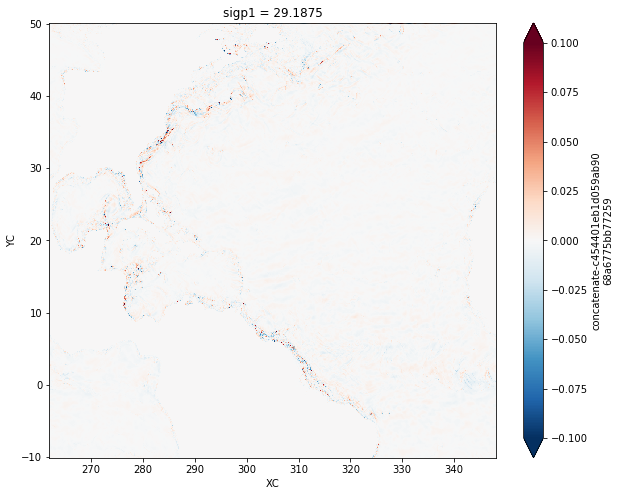

In [51]:
(whash[:,:,25]*86400).plot(vmax=.1, figsize=(10,8))

In [ ]:
# dvdx = grids.diff(vdz*dzetaFy**-1*ds.dyC,'X') * ds.rAz**-1
# dudy = grids.diff(udz*dzetaFx**-1*ds.dxC,'Y',boundary='fill') * ds.rAz**-1
vort = (grids.diff(vhat_snap*ds.dyC,'X') 
        - grids.diff(uhat_snap*ds.dxC,'Y',boundary='fill')
       ) * ds.rAz**-1
Pi = ((grids.interp(grids.interp(vort,'X'),'Y',boundary='fill') 
       + fC) * sigmab**-1)
Pi_f = (1. + grids.interp(grids.interp(vort,'X'),
                          'Y',boundary='fill') * fC**-1
       ) * sigmab**-1
Pi

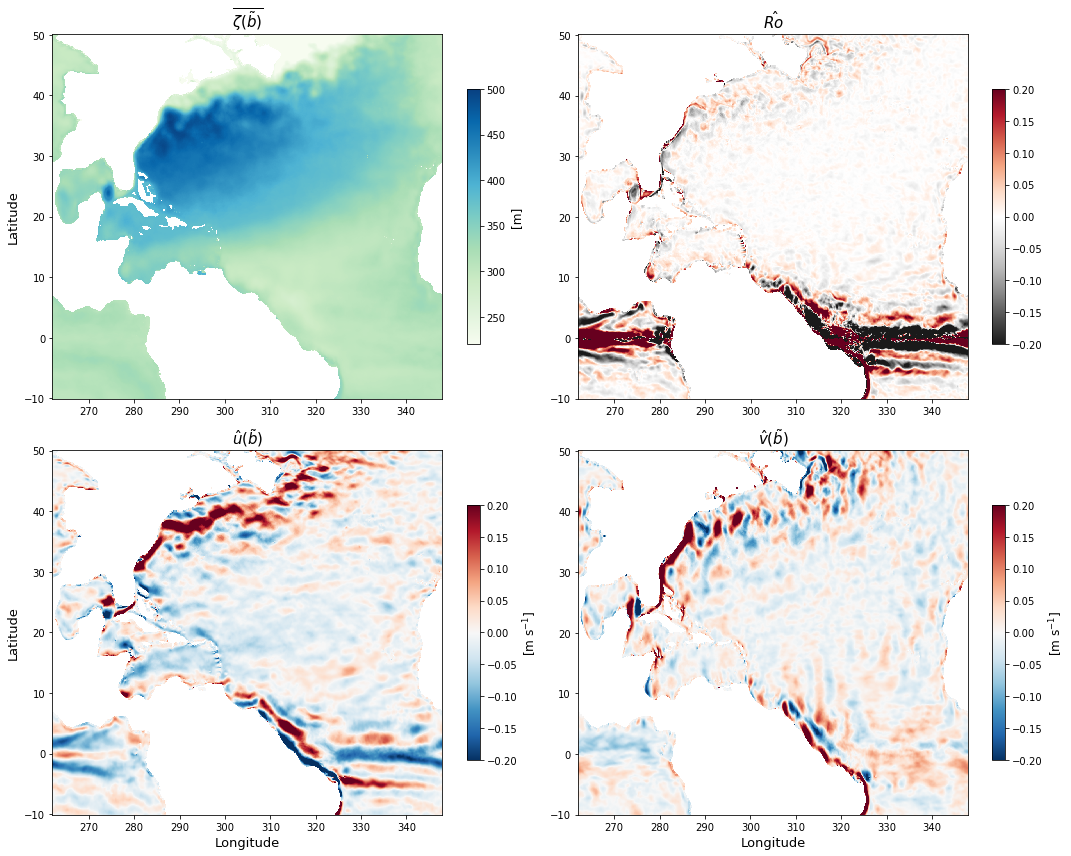

In [31]:
fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dzetaF_snap.XC, dzetaF_snap.YC, 
                           -(zdz_snap*dzetaF_snap**-1).mean('nmemb')[:,:,16],
                           vmin=2.2e2, vmax=5e2, cmap='GnBu', rasterized=True)
im1 = axes[0,1].pcolormesh(uhat_snap.XG, vhat_snap.YG, 
                           (vort*fG**-1)[:,:,16],
                           vmin=-.15e0, vmax=.15e0, cmap='RdGy_r', rasterized=True)
im2 = axes[1,0].pcolormesh(uhat_snap.XG, uhat_snap.YC, uhat_snap[:,:,16], 
                           vmin=-.2e0, vmax=.2e0, 
                           cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(vhat_snap.XC, vhat_snap.YG, vhat_snap[:,:,16], 
                           vmin=-.2e0, vmax=.2e0, 
                           cmap='RdBu_r', rasterized=True)
# vpp[:,:,:,25].mean(['nmemb']).plot(ax=axes[0,1], vmin=-.5e-2, vmax=.5e-2, cmap='RdBu_r')
# (zetap)[:,:,:,25].mean(['nmemb']).where(ds.maskInC!=0.).plot(ax=axes[1,0], vmin=-1e-11, vmax=1e-11, 
#                                                              cmap='RdBu_r')
# varpipp[:,:,:,25].mean(['nmemb']).where(ds.maskInC!=0.).plot(ax=axes[1,1], vmax=1e-9, vmin=-1e-9, 
#                                                              cmap='RdBu_r')

axes[0,0].set_title(r"$\overline{\zeta(\tilde{b})}$", fontsize=15)
axes[0,1].set_title(r"$\hat{Ro}$", fontsize=15)
axes[1,0].set_title(r"$\hat{u}(\tilde{b})$", fontsize=15)
axes[1,1].set_title(r"$\hat{v}(\tilde{b})$", fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
cbar0.set_label(r"[m]", fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
# cbar1.set_label(r"[m d$^{-1}$]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m s$^{-1}$]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
cbar3.set_label(r"[m s$^{-1}$]", fontsize=12)

# plt.savefig(op.join(savedir,'Figures/mean_1963-Dec-26.pdf'))

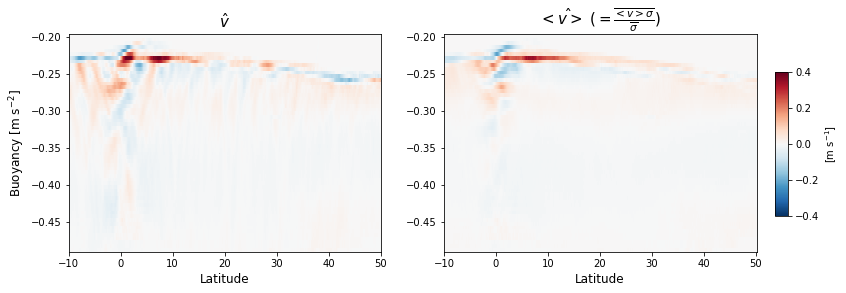

In [55]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,4))
# fig.set_tight_layout(True)
im = ax1.pcolormesh(vdz_snap.YG, buoyb,
                   ((vdz_snap*dzetaFy_snap**-1*dsnap.rAs).sum(['nmemb','XC']) 
                    * dsnap.rAs.sum('XC')**-1).T,
                   vmax=.4, vmin=-.4, cmap='RdBu_r', rasterized=True)
ax2.pcolormesh(vdz_tave.YG, buoyb,
               ((vdz_tave*dzetaFy_tave**-1*dsnap.rAs).sum(['nmemb','XC']) 
                * dsnap.rAs.sum('XC')**-1).T,
               vmax=.4, vmin=-.4, cmap='RdBu_r', rasterized=True)
ax1.set_title(r"$\hat{v}$", fontsize=15)
ax2.set_title(r"$\hat{<v>}$ ($=\frac{\overline{<v>\sigma}}{\overline{\sigma}}$)", fontsize=15)
ax1.set_xlabel(r"Latitude", fontsize=12)
ax2.set_xlabel(r"Latitude", fontsize=12)
ax1.set_ylabel(r"Buoyancy [m s$^{-2}$]", fontsize=12)
fig.subplots_adjust(right=0.86)
# cbaxes = fig.add_axes([0.2, 0.08, 0.6, 0.01]) 
cbaxes = fig.add_axes([0.88, 0.25, 0.014, 0.5]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
cbar.set_label(r"[m s$^{-1}$]")
plt.savefig(op.join(savedir,'Figures/AMOC_1963-Dec-26.pdf'))

## $${\bf E} = \left(\begin{array}{ccc} 
\widehat{u''u''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2} & \widehat{v''u''} & 0 \\
\widehat{u''v''} & \widehat{v''v''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2} & 0 \\
\widehat{\varpi''u''} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_x'} & \widehat{\varpi''v''} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_y'} & 0
\end{array}\right)
$$

where
$$\varpi \equiv \kappa\nabla^2 b = \kappa \Big[\frac{\partial b}{\partial \theta} (\nabla^2 \theta) + \frac{\partial b}{\partial s} (\nabla^2 s)\Big]$$

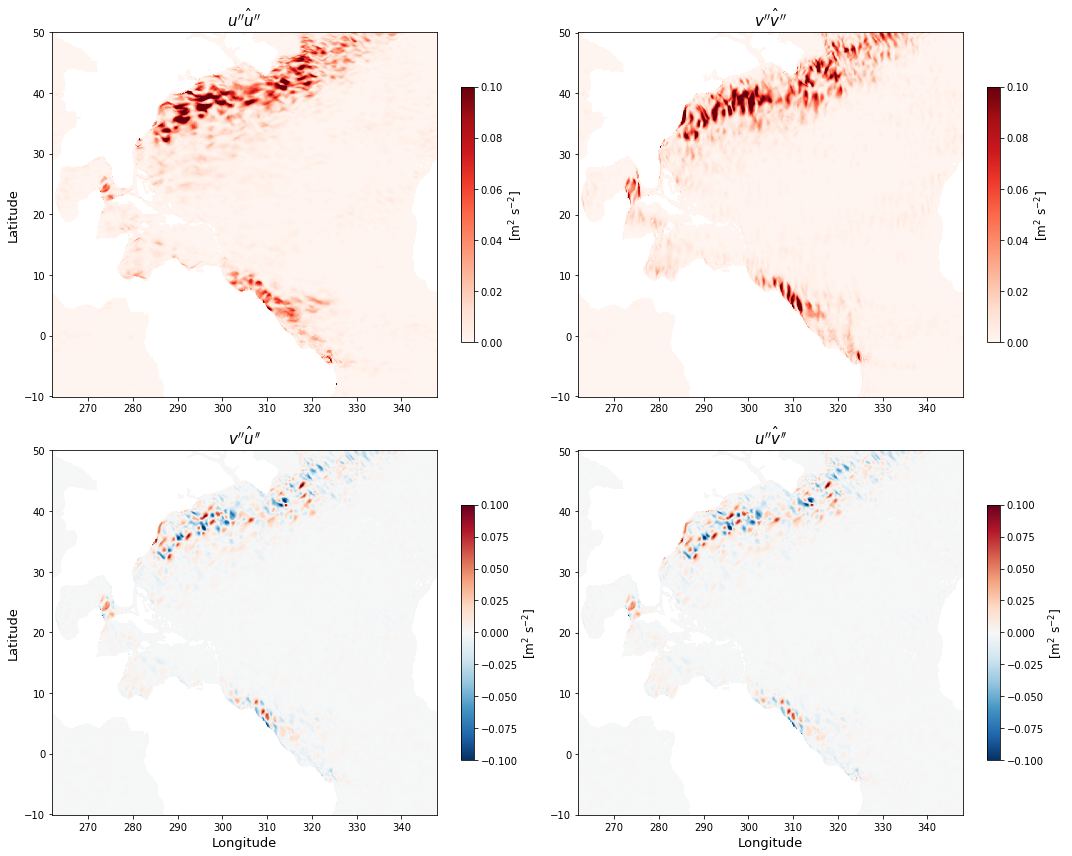

In [31]:
fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(upp_snap.XG, upp_snap.YC, 
                           ((upp_snap**2*sigmax_snap).mean('nmemb', skipna=True)
                            * sigmax_snap.mean('nmemb', skipna=True)**-1
                           )[:,:,16],
                           vmin=0., vmax=.1e0, cmap='Reds', rasterized=True)
im1 = axes[0,1].pcolormesh(vpp_snap.XC, vpp_snap.YG, 
                           ((vpp_snap**2*sigmay_snap).mean('nmemb', skipna=True)
                            * sigmay_snap.mean('nmemb', skipna=True)**-1
                           )[:,:,16],
                           vmin=0., vmax=.1e0, cmap='Reds', rasterized=True)
im2 = axes[1,0].pcolormesh(upp_snap.XG, upp_snap.YC, 
                           ((grids.interp(grids.interp(vpp_snap,'X'),'Y',boundary='fill') 
                             * upp_snap*sigmax_snap).mean('nmemb', skipna=True)
                            * sigmax_snap.mean('nmemb', skipna=True)**-1
                           )[:,:,16], 
                           vmin=-.1e0, vmax=.1e0, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(vpp_snap.XC, vpp_snap.YG, 
                           ((grids.interp(grids.interp(upp_snap,'X'),'Y',boundary='fill') 
                             * vpp_snap*sigmay_snap).mean('nmemb', skipna=True)
                            * sigmay_snap.mean('nmemb', skipna=True)**-1
                           )[:,:,16], 
                           vmin=-.1e0, vmax=.1e0, cmap='RdBu_r', rasterized=True)
# vpp[:,:,:,25].mean(['nmemb']).plot(ax=axes[0,1], vmin=-.5e-2, vmax=.5e-2, cmap='RdBu_r')
# (zetap)[:,:,:,25].mean(['nmemb']).where(ds.maskInC!=0.).plot(ax=axes[1,0], vmin=-1e-11, vmax=1e-11, 
#                                                              cmap='RdBu_r')
# varpipp[:,:,:,25].mean(['nmemb']).where(ds.maskInC!=0.).plot(ax=axes[1,1], vmax=1e-9, vmin=-1e-9, 
#                                                              cmap='RdBu_r')

axes[0,0].set_title(r"$\hat{u''u''}$", fontsize=15)
axes[0,1].set_title(r"$\hat{v''v''}$", fontsize=15)
axes[1,0].set_title(r"$\hat{v''u''}$", fontsize=15)
axes[1,1].set_title(r"$\hat{u''v''}$", fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
cbar0.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
cbar3.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)

plt.savefig(op.join(savedir,'Figures/TWA-Reynoldsfluxes_1963-Dec-26.pdf'))

In [33]:
upp2x = grids.diff(sigmax_snap.mean('nmemb')
                   * ((upp_snap**2*sigmax_snap).mean('nmemb', skipna=True)
                      * sigmax_snap.mean('nmemb', skipna=True)**-1
                     ) * dsnap.dyG, 'X'
                  ) * dsnap.rA**-1 * sigma_snap.mean('nmemb')**-1
uppvppy = grids.diff(sigmay_snap.mean('nmemb')
                     * ((grids.interp(grids.interp(upp_snap,'X'),'Y',boundary='fill') 
                         * vpp_snap*sigmay_snap).mean('nmemb', skipna=True)
                        * sigmay_snap.mean('nmemb', skipna=True)**-1
                       ) * dsnap.dxG,'Y',boundary='fill'
                    ) * dsnap.rA**-1 * sigma_snap.mean('nmemb')**-1

vppuppx = grids.diff(sigmax_snap.mean('nmemb') 
                     * ((grids.interp(grids.interp(vpp_snap,'X'),'Y',boundary='fill') 
                         * upp_snap*sigmax_snap).mean('nmemb', skipna=True)
                        * sigmax_snap.mean('nmemb', skipna=True)**-1
                       ) * dsnap.dyG, 'X'
                    ) * dsnap.rA**-1 * sigma_snap.mean('nmemb')**-1
vpp2y = grids.diff(sigmay_snap.mean('nmemb')
                   * ((vpp_snap**2*sigmay_snap).mean('nmemb', skipna=True)
                      * sigmay_snap.mean('nmemb', skipna=True)**-1
                     ) * dsnap.dxG,'Y',boundary='fill'
                  ) * dsnap.rA**-1 * sigma_snap.mean('nmemb')**-1

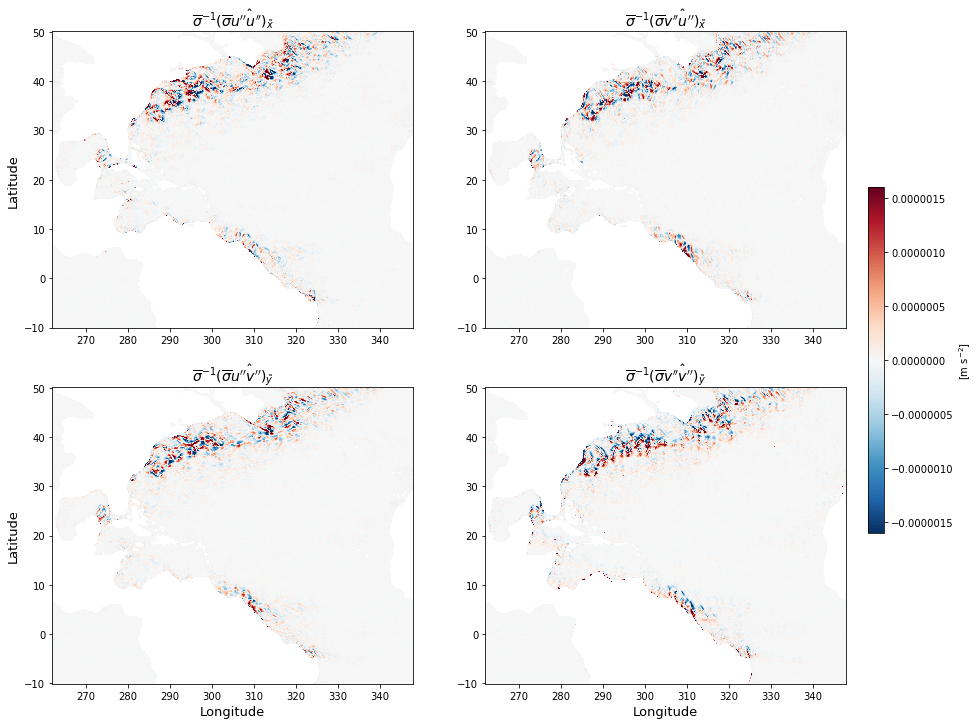

In [37]:
fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(upp2x.XC, upp2x.YC, upp2x[:,:,16], vmax=1.6e-6, vmin=-1.6e-6, 
                          cmap='RdBu_r', rasterized=True)
axes[1,0].pcolormesh(uppvppy.XC, uppvppy.YC, uppvppy[:,:,16], vmax=1.6e-6, vmin=-1.6e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(vppuppx.XC, vppuppx.YC, vppuppx[:,:,16], vmax=1.6e-6, vmin=-1.6e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[1,1].pcolormesh(vpp2y.XC, vpp2y.YC, vpp2y[:,:,16], vmax=1.6e-6, vmin=-1.6e-6, 
                     cmap='RdBu_r', rasterized=True)

axes[0,0].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{u''u''})_\tilde{x}$", 
                    fontsize=14)
axes[1,0].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{u''v''})_\tilde{y}$", fontsize=14)
axes[0,1].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{v''u''})_\tilde{x}$", fontsize=14)
# axes[0,0].set_title(r"$\overline{\zeta}$", fontsize=15)
axes[1,1].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{v''v''})_\tilde{y}$", 
                    fontsize=14)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86)
# cbaxes = fig.add_axes([0.2, 0.08, 0.6, 0.01]) 
cbaxes = fig.add_axes([0.88, 0.3, 0.015, 0.4]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
cbar.set_label(r"[m s$^{-2}$]")

plt.savefig(op.join(savedir,'Figures/Div_TWA-Reynoldsflux_1963-Dec-26.pdf'))

In [ ]:
# e00_snap = (((upp_snap**2*sigmax_snap).mean('nmemb', skipna=True) 
#              + (zetaxp_snap**2).mean('nmemb', skipna=True)*.5
#             ) * sigmax_snap.mean('nmemb', skipna=True)**-1).compute()
# print("e00 done.")
# e01_snap = (((grids.interp(grids.interp(vpp_snap,'X'),'Y',boundary='fill') 
#               * upp_snap*sigmax_snap).mean('nmemb', skipna=True)
#              * sigmax_snap.mean('nmemb', skipna=True)**-1)).compute()
# print("e01 done.")
# e10_snap = (((grids.interp(grids.interp(upp_snap,'X'),'Y',boundary='fill') 
#               * vpp_snap*sigmay_snap).mean('nmemb', skipna=True)
#              * sigmay_snap.mean('nmemb', skipna=True)**-1)).compute()
# print("e01 done.")
# e11_snap = (((vpp_snap**2*sigmay_snap).mean('nmemb', skipna=True) 
#              + (zetayp_snap**2).mean('nmemb', skipna=True)*.5
#             ) * sigmay_snap.mean('nmemb', skipna=True)**-1).compute()
# print("e11 done.")
# # e20_snap = (grids.interp((mbxp_snap*zetaxp_snap).mean('nmemb', skipna=True),'X')
# #            ) * sigma_snap.mean('nmemb', skipna=True)**-1
# # e21_snap = (grids.interp((mbyp_snap*zetayp_snap).mean('nmemb', skipna=True),'Y',boundary='fill')
# #            ) * sigma_snap.mean('nmemb', skipna=True)**-1
# # e20_snap = (((varpipp*grids.interp(upp_snap,'X')*sigma_snap
# #               + grids.interp((mbxp_snap*zetaxp_snap),'X')).mean('nmemb', skipna=True) 
# #             ) * sigma_snap.mean('nmemb', skipna=True)**-1).compute()
# e20_snap = (((varpipp*grids.interp(upp_snap,'X')*sigma_snap).mean('nmemb', skipna=True)
#              * sigma_snap.mean('nmemb', skipna=True)**-1).compute()
#             + (grids.interp((mbxp_snap*zetaxp_snap).mean('nmemb', skipna=True),'X')
#                * sigma_snap.mean('nmemb', skipna=True)**-1).compute()
#            )
# print("e20 done.")
# # e21_snap = (((varpipp*grids.interp(vpp_snap,'Y',boundary='fill')*sigma_snap
# #               + grids.interp((mbyp_snap*zetayp_snap),'Y',boundary='fill')).mean('nmemb', skipna=True) 
# #             ) * sigma_snap.mean('nmemb', skipna=True)**-1).compute()
# e21_snap = (((varpipp*grids.interp(vpp_snap,'Y',boundary='fill')*sigma_snap).mean('nmemb', skipna=True)
#              * sigma_snap.mean('nmemb', skipna=True)**-1).compute()
#             + (grids.interp((mbyp_snap*zetayp_snap).mean('nmemb', skipna=True),'Y',boundary='fill')
#                * sigma_snap.mean('nmemb', skipna=True)**-1).compute()
#            )
# print("e21 done.")

# e00_tave = ((upp_tave**2*sigmax_tave).mean('nmemb', skipna=True) 
#             + (zetaxp_tave**2).mean('nmemb', skipna=True)*.5
#            ) * sigmax_tave.mean('nmemb', skipna=True)**-1
# e01_tave = ((grids.interp(grids.interp(vpp_tave,'X'),'Y',boundary='fill') 
#              * upp_tave*sigmax_tave).mean('nmemb', skipna=True)
#             * sigmax_tave.mean('nmemb', skipna=True)**-1)
# e10_tave = ((grids.interp(grids.interp(upp_tave,'X'),'Y',boundary='fill') 
#              * vpp_tave*sigmay_tave).mean('nmemb', skipna=True)
#             * sigmay_tave.mean('nmemb', skipna=True)**-1)
# e11_tave = ((vpp_tave**2*sigmay_tave).mean('nmemb', skipna=True) 
#             + (zetayp_tave**2).mean('nmemb', skipna=True)*.5
#            ) * sigmay_tave.mean('nmemb', skipna=True)**-1
# e20_tave = (grids.interp((mbxp_tave*zetaxp_tave).mean('nmemb', skipna=True),'X')
#            ) * sigma_tave.mean('nmemb', skipna=True)**-1
# e21_tave = (grids.interp((mbyp_tave*zetayp_tave).mean('nmemb', skipna=True),'Y',boundary='fill')
#            ) * sigma_tave.mean('nmemb', skipna=True)**-1

sigmab = (dzetaF_snap.mean('nmemb',skipna=True) 
          * -grids.diff(buoybp1,'Z',boundary='fill')**-1
         )
sigmaxb = (dzetaFx_snap.mean('nmemb',skipna=True) 
           * -grids.diff(buoybp1,'Z',boundary='fill')**-1
          )
sigmayb = (dzetaFy_snap.mean('nmemb',skipna=True) 
           * -grids.diff(buoybp1,'Z',boundary='fill')**-1
          )
# sigmazb = (dzetaFz_snap.mean('nmemb',skipna=True) 
#            * -grids.diff(buoybp1,'Z',boundary='fill')**-1
#           )

tmp00 = ((upp_snap**2*sigmax_snap)
         + .5*(zetaxp_snap**2)
        ).mean('nmemb',skipna=True)
tmp01 = (grids.interp(grids.interp(vpp_snap,'X'),'Y',boundary='fill')
         * upp_snap*sigmax_snap).mean('nmemb',skipna=True)
tmp10 = (grids.interp(grids.interp(upp_snap,'X'),'Y',boundary='fill') 
         * vpp_snap*sigmay_snap).mean('nmemb',skipna=True)
tmp11 = ((vpp_snap**2*sigmay_snap) 
         + .5*(zetayp_snap**2)
        ).mean('nmemb',skipna=True)
tmp20 = ((varpipp*grids.interp(upp_snap,'X')*sigma_snap)
         + grids.interp(mbxp_snap*zetaxp_snap,'X')
        ).mean('nmemb',skipna=True)
tmp21 = ((varpipp*grids.interp(vpp_snap,'Y',boundary='fill')*sigma_snap)
         + grids.interp(mbyp_snap*zetayp_snap,'Y',boundary='fill')
        ).mean('nmemb',skipna=True)

e00_snap = (tmp00 * sigmaxb**-1).compute()
e01_snap = (tmp01 * sigmaxb**-1).compute()
e10_snap = (tmp10 * sigmayb**-1).compute()
e11_snap = (tmp11 * sigmayb**-1).compute()
e20_snap = (tmp20 * sigmab**-1).compute()
e21_snap = (tmp21 * sigmab**-1).compute()

# print(e00_snap,e01_snap,e20_snap)

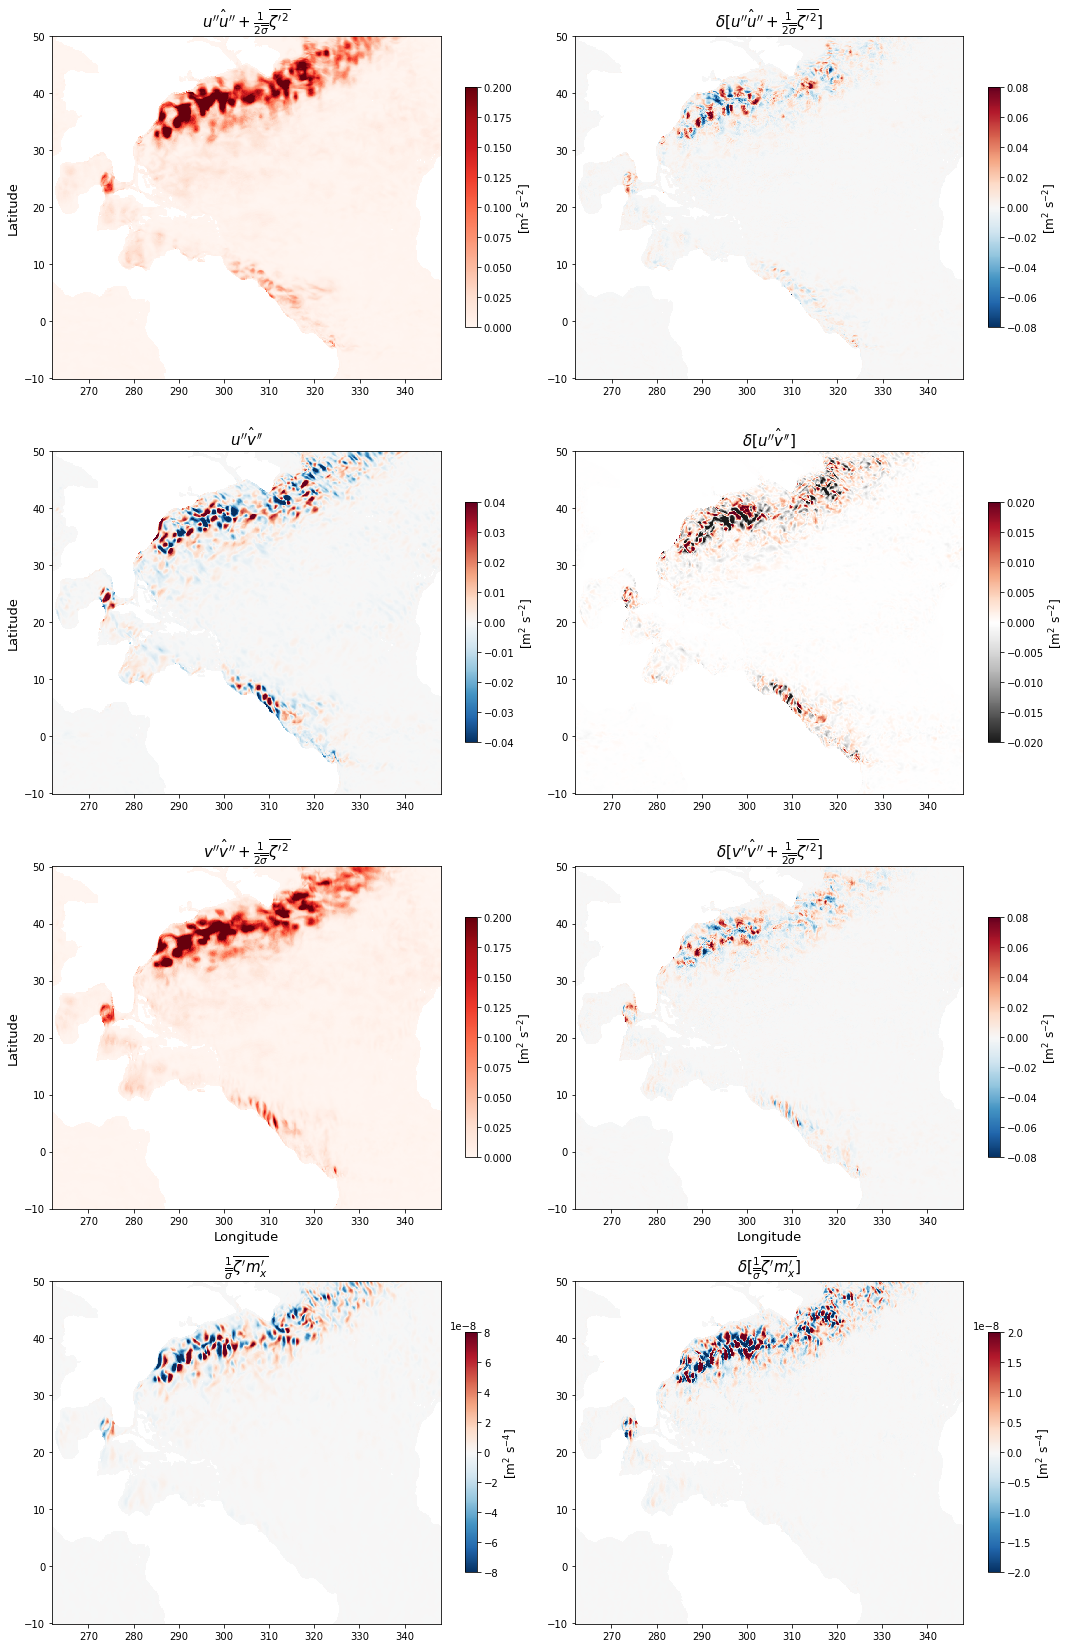

In [47]:
fig, axes = plt.subplots(figsize=(15,23), nrows=4, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(e00_snap.XG, e00_snap.YC, e00_snap[:,:,16], vmax=2e-1, vmin=0, 
                           cmap='Reds', rasterized=True)
im1 = axes[0,1].pcolormesh(e00_tave.XG, e00_tave.YC, (e00_snap-e00_tave)[:,:,16], vmax=8e-2, vmin=-8e-2, 
                           cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(e01_snap.XG, e01_snap.YC, e01_snap[:,:,16], vmax=4e-2, vmin=-4e-2, 
                           cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(e01_tave.XG, e01_tave.YC, (e01_snap-e01_tave)[:,:,16], vmax=2e-2, vmin=-2e-2, 
                           cmap='RdGy_r', rasterized=True)
im4 = axes[2,0].pcolormesh(e11_snap.XC, e11_snap.YG, e11_snap[:,:,16], vmax=2e-1, vmin=0, 
                           cmap='Reds', rasterized=True)
im5 = axes[2,1].pcolormesh(e11_tave.XC, e11_tave.YG, (e11_snap-e11_tave)[:,:,16], vmax=8e-2, vmin=-8e-2, 
                           cmap='RdBu_r', rasterized=True)
im6 = axes[3,0].pcolormesh(e20_snap.XC, e20_snap.YC, e20_snap[:,:,16], vmax=8e-8, vmin=-8e-8, 
                           cmap='RdBu_r', rasterized=True)
im7 = axes[3,1].pcolormesh(e20_tave.XC, e20_tave.YC, (e20_snap-e20_tave)[:,:,16], vmax=2e-8, vmin=-2e-8, 
                           cmap='RdBu_r', rasterized=True)

axes[0,0].set_title(r"$\hat{u''u''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}$", fontsize=15)
axes[0,1].set_title(r"$\delta[\hat{u''u''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}]$", 
                    fontsize=15)
axes[1,0].set_title(r"$\hat{u''v''}$", fontsize=15)
axes[1,1].set_title(r"$\delta[\hat{u''v''}]$", fontsize=15)
axes[2,0].set_title(r"$\hat{v''v''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}$", 
                    fontsize=15)
axes[2,1].set_title(r"$\delta[\hat{v''v''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}]$", 
                    fontsize=15)
axes[3,0].set_title(r"$\frac{1}{\overline{\sigma}}\overline{\zeta'm_x'}$", 
                    fontsize=15)
axes[3,1].set_title(r"$\delta[\frac{1}{\overline{\sigma}}\overline{\zeta'm_x'}]$", 
                    fontsize=15)
# axes[2,1].set_title(r"$\hat{\varpi''v''} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_y'}$", 
#                     fontsize=15)
axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
cbar0.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
cbar3.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar4 = fig.colorbar(im4, ax=axes[2,0], shrink=.7)
cbar4.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar5 = fig.colorbar(im5, ax=axes[2,1], shrink=.7)
cbar5.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar6 = fig.colorbar(im6, ax=axes[3,0], shrink=.7)
cbar6.set_label(r"[m$^2$ s$^{-4}$]", fontsize=12)
cbar7 = fig.colorbar(im7, ax=axes[3,1], shrink=.7)
cbar7.set_label(r"[m$^2$ s$^{-4}$]", fontsize=12)

plt.savefig(op.join(savedir,'Figures/E-P_flux_Sub5DayDiff_1963-Dec-26.pdf'))

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(15,6), nrows=1, ncols=3)
# fig.set_tight_layout(True)

im0 = ax1.pcolormesh(e00_snap.XG, e00_snap.YC, (e00_snap-e00_tave)[:,:,18], vmax=1e-2, vmin=-1e-2, 
                     cmap='RdBu_r', rasterized=True)
im2 = ax2.pcolormesh(e01_snap.XG, e01_snap.YC, (e01_snap-e01_tave)[:,:,18], vmax=1e-2, vmin=-1e-2, 
                     cmap='RdBu_r', rasterized=True)
im4 = ax3.pcolormesh(e11_snap.XC, e11_snap.YG, (e11_snap-e11_tave)[:,:,18], vmax=1e-2, vmin=-1e-2, 
                     cmap='RdBu_r', rasterized=True)

ax1.set_title(r"$\delta[\hat{u''u''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}]$", fontsize=15)
ax2.set_title(r"$\delta[\hat{u''v''}]$", fontsize=15)
# # axes[1,0].set_title(r"$\hat{v''u''}$", fontsize=15)
# axes[0,0].set_title(r"$\overline{\Pi}/f$", fontsize=15)
ax3.set_title(r"$\delta[\hat{v''v''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}]$", 
             fontsize=15)
# axes[2,0].set_title(r"$\hat{\varpi''u''} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_x'}$", 
#                     fontsize=15)
# axes[2,1].set_title(r"$\hat{\varpi''v''} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_y'}$", 
#                     fontsize=15)
ax1.set_xlabel(r"Longitude", fontsize=13)
ax2.set_xlabel(r"Longitude", fontsize=13)
ax3.set_xlabel(r"Longitude", fontsize=13)
ax1.set_ylabel(r"Latitude", fontsize=13)

# cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
# cbar0.set_label(r"[s$^2$]", fontsize=12)
# cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
# cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
# cbar4 = fig.colorbar(im4, ax=axes[2,0], shrink=.7)
# cbar4.set_label(r"[m$^2$ s$^{-4}$]", fontsize=12)

fig.subplots_adjust(bottom=0.23)
# cbaxes = fig.add_axes([0.2, 0.08, 0.6, 0.01]) 
cbaxes = fig.add_axes([0.3, 0.12, 0.4, 0.015]) 
cbar = fig.colorbar(im0, orientation='horizontal', cax=cbaxes)
cbar.set_label(r"[m s$^{-2}$]", fontsize=14)

plt.savefig(op.join(savedir,'Figures/E-P_flux_Sub5DayDiff_1963-Dec-26.pdf'))

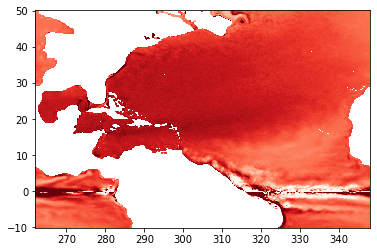

In [33]:
plt.pcolormesh(Pi.XC.data, Pi.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data, 
               Pi[:,:,16].data, 
               vmin=.3e-4, vmax=1.1e-4, cmap='Reds', rasterized=True)

In [ ]:
fig, axes = plt.subplots(figsize=(15,17), nrows=3, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsnap.XC.data, dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data, 
                           Pi.isel(sig=16).data, 
                           vmin=.3e-4, vmax=1.1e-4, cmap='Reds', rasterized=True)
im1 = axes[0,1].pcolormesh(dsnap.XG.data, dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data, 
                           e01_snap.isel(sig=16).data, 
                           vmax=4e-2, vmin=-4e-2, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsnap.XG.data, dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data, 
                           e00_snap.isel(sig=16).data, 
                           vmax=2e-1, vmin=0, cmap='Reds', rasterized=True)
im3 = axes[1,1].pcolormesh(dsnap.XC.data, dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data, 
                           e11_snap.isel(sig=16).data, 
                           vmax=2e-1, vmin=0, cmap='Reds', rasterized=True)
im4 = axes[2,0].pcolormesh(dsnap.XC.data, dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data, 
                           e20_snap.isel(sig=16).data, 
                           vmax=1e-7, vmin=-1e-7, cmap='RdBu_r', rasterized=True)
im5 = axes[2,1].pcolormesh(dsnap.XC.data, dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data, 
                           e21_snap.isel(sig=16).data, 
                           vmax=1e-7, vmin=-1e-7, cmap='RdBu_r', rasterized=True)

axes[1,0].set_title(r"$\hat{u''u''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}$", fontsize=15)
axes[0,1].set_title(r"$\hat{u''v''}$", fontsize=15)
axes[0,0].set_title(r"$\Pi^\#/f$", fontsize=15)
axes[1,1].set_title(r"$\hat{v''v''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}$", fontsize=15)
axes[2,0].set_title(r"$\hat{\varpi''u''} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_x'}$", fontsize=15)
axes[2,1].set_title(r"$\hat{\varpi''v''} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_y'}$", fontsize=15)
axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
cbar0.set_label(r"[s$^2$]", fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
cbar3.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar4 = fig.colorbar(im4, ax=axes[2,0], shrink=.7)
cbar4.set_label(r"[m$^2$ s$^{-4}$]", fontsize=12)
cbar5 = fig.colorbar(im5, ax=axes[2,1], shrink=.7)
cbar5.set_label(r"[m$^2$ s$^{-4}$]", fontsize=12)

# plt.savefig(op.join(savedir,'Figures/E-P_flux_1963-Dec-26.pdf'))

## Divergence of the E-P flux tensor
#### $$\mathbf{e}_1\cdot(\nabla\cdot{\bf E}) = \overline{\sigma}^{-1}\Big[\partial_\tilde{x}\big[\overline{\sigma}\widehat{u''u''} + \frac{1}{2}\overline{\zeta'^2}\big] + \partial_\tilde{y}(\overline{\sigma}\widehat{u''v''}) + \partial_\tilde{b}\big[\overline{\sigma}\widehat{\varpi''u''} + \overline{\zeta'm_x'}\big]\Big]$$
#### $$\mathbf{e}_2\cdot(\nabla\cdot{\bf E}) = \overline{\sigma}^{-1}\Big[\partial_\tilde{x}(\overline{\sigma}\widehat{v''u''}) + \partial_\tilde{y}\big[\overline{\sigma}\widehat{v''v''} + \frac{1}{2}\overline{\zeta'^2}\big] + \partial_\tilde{b}\big[\overline{\sigma}\widehat{\varpi''v''} + \overline{\zeta'm_y'}\big]\Big]$$

In [50]:
# e00x = grids.diff(sigmax_snap.mean('nmemb')*e00_snap*dsnap.dyG,
#                   'X') * dsnap.rA**-1 * sigma_snap.mean('nmemb')**-1
# e10y = grids.diff(sigmay_snap.mean('nmemb')*e10_snap*dsnap.dxG,
#                   'Y',boundary='fill') * dsnap.rA**-1 * sigma_snap.mean('nmemb')**-1
# e20b = grids.interp(grids.diff(sigma_snap.mean('nmemb')*e20_snap,'Z',boundary='fill') 
#                     * grids.diff(buoyb,'Z',boundary='fill')**-1,
#                     'Z',boundary='fill') * sigma_snap.mean('nmemb')**-1
# e01x = grids.diff(sigmax_snap.mean('nmemb')*e01_snap*dsnap.dyG,
#                   'X') * dsnap.rA**-1 * sigma_snap.mean('nmemb')**-1
# e11y = grids.diff(sigmay_snap.mean('nmemb')*e11_snap*dsnap.dxG,
#                   'Y',boundary='fill') * dsnap.rA**-1 * sigma_snap.mean('nmemb')**-1
# e21b = grids.interp(grids.diff(sigma_snap.mean('nmemb')*e21_snap,'Z',boundary='fill') 
#                     * grids.diff(buoyb,'Z',boundary='fill')**-1,
#                     'Z',boundary='fill') * sigma_snap.mean('nmemb')**-1

e00x = (grid.diff(tmp00*ds.dyG,'X') * ds.rA**-1 
        * sigmab**-1).compute()
e10y = (grid.diff(tmp10*ds.dxG,'Y',boundary='fill') * ds.rA**-1 
        * sigmab**-1).compute()
e20b = (grid.interp(grid.diff(tmp20,'Z',boundary='fill') 
                    * grid.diff(buoyb,'Z',boundary='fill')**-1,
                    'Z',boundary='fill')
        * sigmab**-1).compute()
# e20b = grid.interp(grid.diff(tmp20,'Z',boundary='fill') 
#                    * grid.diff(buoyb,'Z',boundary='fill')**-1
#                    * sigmazb**-1,
#                    'Z',boundary='fill').compute()
e01x = (grid.diff(tmp01*ds.dyG,'X') * ds.rA**-1 
        * sigmab**-1).compute()
e11y = (grid.diff(tmp11*ds.dxG,'Y',boundary='fill') * ds.rA**-1 
        * sigmab**-1).compute()
e21b = (grid.interp(grid.diff(tmp21,'Z',boundary='fill') 
                    * grid.diff(buoyb,'Z',boundary='fill')**-1,
                    'Z',boundary='fill') 
        * sigmab**-1).compute()
# e21b = grid.interp(grid.diff(tmp21,'Z',boundary='fill') 
#                    * grid.diff(buoyb,'Z',boundary='fill')**-1 
#                    * sigmazb**-1,
#                    'Z',boundary='fill').compute()
print(e00x,e10y,e20b,e01x,e11y,e21b)

<xarray.DataArray (YC: 723, XC: 1000, sig: 60)>
dask.array<mul, shape=(723, 1000, 60), dtype=float64, chunksize=(723, 249, 10), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -10.08 -10.0 -9.917 -9.833 ... 49.83 49.92 50.0 50.08
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0
    maskInC  (YC, XC) bool dask.array<chunksize=(723, 250), meta=np.ndarray>
    rA       (YC, XC) >f4 dask.array<chunksize=(723, 250), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(723, 250), meta=np.ndarray> <xarray.DataArray (YC: 723, XC: 1000, sig: 60)>
dask.array<mul, shape=(723, 1000, 60), dtype=float64, chunksize=(721, 249, 10), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -10.08 -10.0 -9.917 -9.833 ... 49.83 49.92 50.0 50.08
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 

In [ ]:
Eu = e00x + e10y + e20b
Ev = e01x + e11y + e21b
PVp_x = sigmab**-1 * Ev
PVp_y = -sigmab**-1 * Eu

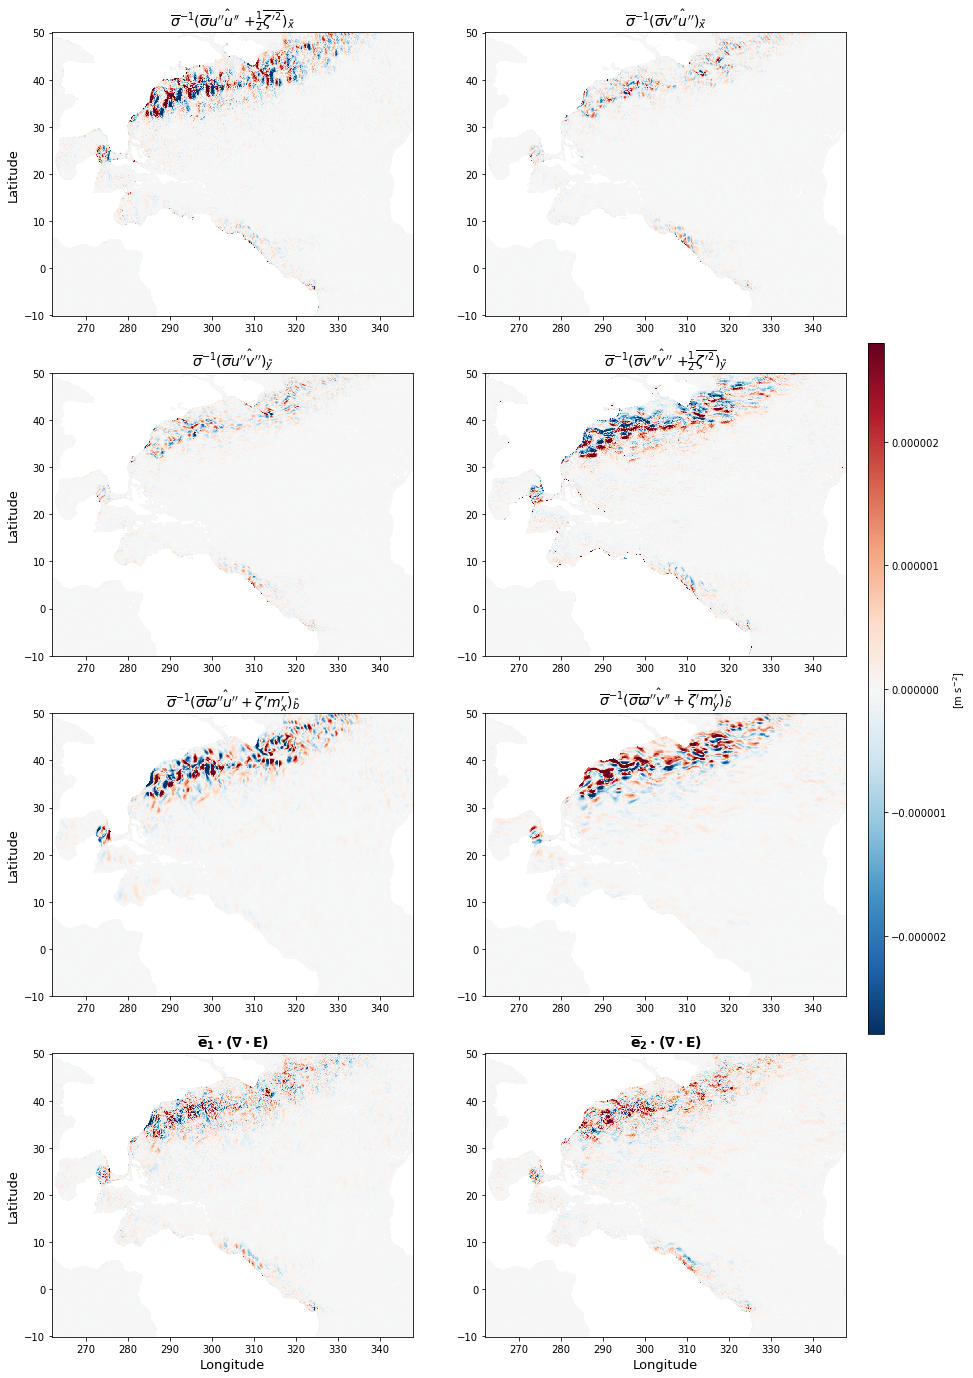

In [53]:
fig, axes = plt.subplots(figsize=(14,24), nrows=4, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(e00x.XC, e00x.YC, e00x.isel(sig=16), vmax=2.8e-6, vmin=-2.8e-6, 
                          cmap='RdBu_r', rasterized=True)
axes[1,0].pcolormesh(e10y.XC, e10y.YC, e10y.isel(sig=16), vmax=2.8e-6, vmin=-2.8e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(e01x.XC, e01x.YC, e01x.isel(sig=16), vmax=2.8e-6, vmin=-2.8e-6, 
                     cmap='RdBu_r', rasterized=True)
# (zdz*dzetaF**-1).mean('nmemb')[:,:,25].plot(ax=axes[0,0], vmin=-6e2, vmax=-3e2, cmap='Blues_r', rasterized=True)
axes[1,1].pcolormesh(e11y.XC, e11y.YC, e11y.isel(sig=16), vmax=2.8e-6, vmin=-2.8e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[2,0].pcolormesh(e20b.XC, e20b.YC, e20b.isel(sig=16), vmax=2.8e-6, vmin=-2.8e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(e21b.XC, e21b.YC, e21b.isel(sig=16), vmax=2.8e-6, vmin=-2.8e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[3,0].pcolormesh(e00x.XC, e00x.YC, Eu.isel(sig=16), vmax=2.8e-6, vmin=-2.8e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[3,1].pcolormesh(e01x.XC, e01x.YC, Ev.isel(sig=16), vmax=2.8e-6, vmin=-2.8e-6, 
                     cmap='RdBu_r', rasterized=True)

axes[0,0].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{u''u''}$ "
                    + r"$+ \frac{1}{2}\overline{\zeta'^2})_\tilde{x}$", 
                    fontsize=14)
axes[1,0].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{u''v''})_\tilde{y}$", fontsize=14)
axes[0,1].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{v''u''})_\tilde{x}$", fontsize=14)
# axes[0,0].set_title(r"$\overline{\zeta}$", fontsize=15)
axes[1,1].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{v''v''}$ "
                    + r"$+ \frac{1}{2}\overline{\zeta'^2})_\tilde{y}$", 
                    fontsize=14)
axes[2,0].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{\varpi''u''} + \overline{\zeta'm_x'})_\tilde{b}$", 
                    fontsize=14)
axes[2,1].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{\varpi''v''} + \overline{\zeta'm_y'})_\tilde{b}$", 
                    fontsize=14)
axes[3,0].set_title(r"$\overline{\bf e}_1\cdot(\nabla\cdot{\bf E})$", fontsize=14)
axes[3,1].set_title(r"$\overline{\bf e}_2\cdot(\nabla\cdot{\bf E})$", fontsize=14)

axes[3,0].set_xlabel(r"Longitude", fontsize=13)
axes[3,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)
axes[3,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86)
# cbaxes = fig.add_axes([0.2, 0.08, 0.6, 0.01]) 
cbaxes = fig.add_axes([0.88, 0.35, 0.018, 0.3]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
cbar.set_label(r"[m s$^{-2}$]")

# plt.savefig(op.join(savedir,'Figures/Div_E-P_flux_1963-Dec-26.pdf'))

In [ ]:
vort_x = grid.diff(vort*grid.interp(ds.dyC,'X'),'X') * ds.rAs**-1
vort_y = grid.diff(vort*grid.interp(ds.dxC,'Y',boundary='fill'),
                   'Y',boundary='fill') * ds.rAw**-1

zetab_x = grid.diff(zetaxb*ds.dyG,'X') * ds.rA**-1
zetab_y = grid.diff(zetayb*ds.dxG,'Y',boundary='fill') * ds.rA**-1
# dzetab_x = grid.diff(dsz.dzetaFx.mean('nmemb')*ds.dyG,'X') * ds.rA**-1
# dzetab_y = grid.diff(dsz.dzetaFy.mean('nmemb')*ds.dxG,'Y',
#                      boundary='fill') * ds.rA**-1

sigmab_x = grid.interp(grid.diff(zetab_x,'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
                       'Z',boundary='fill')
sigmab_y = grid.interp(grid.diff(zetab_y,'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
                       'Z',boundary='fill')
# sigmab_x = dzetab_x * -grid.diff(buoybp1,'Z',boundary='fill')**-1
# sigmab_y = dzetab_y * -grid.diff(buoybp1,'Z',boundary='fill')**-1
# # sigb_x_sigb = grid.diff(np.log(sigmaxb)*ds.dyG,'X') * ds.rA**-1
# # sigb_y_sigb = grid.diff(np.log(sigmayb)*ds.dxG,'Y',boundary='fill') * ds.rA**-1

absvort = fC + grid.interp(grid.interp(vort,'X'),'Y',boundary='fill')
Pi_xs = (grid.interp(vort_x,'Y',boundary='fill')
         - sigmab_x * sigmab**-1 * absvort)
Pi_ys = (grid.diff(fG,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1 
         + grid.interp(vort_y,'X')
        ) - sigmab_y * sigmab**-1 * absvort
# Pi_xs = (grid.interp(vort_x,'Y',boundary='fill')
#          - absvort * sigb_x_sigb)
# Pi_ys = (grid.diff(fG,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1 
#          + grid.interp(vort_y,'X')
#         ) - absvort * sigb_y_sigb

Pi_x = Pi_xs * sigmab**-1
Pi_y = Pi_ys * sigmab**-1

In [ ]:
fig, axes = plt.subplots(figsize=(14,12), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsz.XC, dsz.YC, -PVp_x.isel(sig=16), 
                           vmin=-2e-10, vmax=2e-10, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsz.XC, dsz.YC, -PVp_y.isel(sig=16), 
                           vmin=-2e-10, vmax=2e-10, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsz.XC, dsz.YC, -Pi_x.isel(sig=16), 
                           vmin=-2e-14, vmax=2e-14, cmap='coolwarm', rasterized=True)
im3 = axes[1,1].pcolormesh(dsz.XC, dsz.YC, -Pi_y.isel(sig=16), 
                           vmin=-2e-14, vmax=2e-14, cmap='coolwarm', rasterized=True)
# im4 = axes[2,0].pcolormesh(dsz.XC, dsz.YC, kappax.isel(sig=16), 
#                            vmax=8e3, vmin=-8e3, cmap='bwr', 
# #                            norm=clr.SymLogNorm(1e2), 
#                            rasterized=True)
# im5 = axes[2,1].pcolormesh(dsz.XC, dsz.YC, kappay.isel(sig=16), 
#                            vmax=8e3, vmin=-8e3, cmap='bwr',
# #                            norm=clr.SymLogNorm(1e2), 
#                            rasterized=True)

axes[0,0].set_title(r"$-\hat{u''\Pi''} (= -\overline{\sigma}^{-1}\overline{\bf e}_1$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=15)
axes[0,1].set_title(r"$-\hat{v''\Pi''} (= \overline{\sigma}^{-1}\overline{\bf e}_2$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=15)
axes[1,0].set_title(r"$-\Pi^\#_\tilde{x}$", fontsize=15)
axes[1,1].set_title(r"$-\Pi^\#_\tilde{y}$", 
                    fontsize=15)
# axes[2,0].set_title(r"$\kappa^u (= -\hat{u''\Pi''}/\Pi^\#_\tilde{x})$", 
#                     fontsize=15)
# axes[2,1].set_title(r"$\kappa^v (= -\hat{v''\Pi''}/\Pi^\#_\tilde{y})$", 
#                     fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
# axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86) 
cbax0 = fig.add_axes([0.88, 0.69, 0.018, 0.17])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m s$^{-4}$]", fontsize=12)
cbax2 = fig.add_axes([0.88, 0.41, 0.018, 0.17])
cbar2 = fig.colorbar(im2, orientation='vertical', cax=cbax2)
cbar2.set_label(r"[m$^{-1}$ s$^{-3}$]", fontsize=12)
# cbax4 = fig.add_axes([0.88, 0.15, 0.018, 0.17])
# cbar4 = fig.colorbar(im4, orientation='vertical', cax=cbax4)
# cbar4.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

# plt.savefig(op.join(ddir,'Figures/PV_flux_1963-Dec-26.pdf'))